In [2]:
import CGA_for_ttp as cga
import numpy as np
from obj_func import obj_func
from read_instance import read_instance
import random
import seaborn as sns
from random import randint
import sys 

In [3]:
file=open(r"E:\monit\Documents\TTP\Instancias\a280-ttp\a280_n279_bounded-strongly-corr_01.ttp","r")
#file=open(r"E:\monit\Documents\TTP\Instancias\a280-ttp\my_test.ttp","r")
dic=read_instance(file)


In [4]:
def create_knap_pop(dic,y,x):
    pop_knap=np.zeros((y,x,dic["number of items"]))
    for i in range(pop_knap.shape[0]):
        for l in range(pop_knap.shape[1]):
            item_pick=[]
            for x in range(dic["number of items"]):
                item_pick.append(random.randint(0, 1))
            item_pick2=np.array(item_pick)
            pop_knap[i,l]=item_pick2
    return pop_knap

In [5]:
def create_tsp_pop(dic,y,x):
    pop_tsp=np.zeros((y,x,dic["number cities"]-1))
    for i in range(pop_tsp.shape[0]):
        for l in range(pop_tsp.shape[1]):
            order_cities=list(range(2,dic["number cities"]+1 ))
            random.shuffle(order_cities)
            pop_tsp[i,l,:]=order_cities
    return pop_tsp

In [6]:
def fit_loop(dic,pop_tsp,pop_knap):
    fitness=np.zeros((Y,X))
    for i in range(Y):
        for l in range(X):
            fitness[i,l]=obj_func(dic,pop_tsp[i,l,:],pop_knap[i,l,:])
    return fitness

generation:  0  maximo:  -1338459.760162806
generation:  1  maximo:  -1316745.6398867823
generation:  2  maximo:  -1293180.2505234026
generation:  3  maximo:  -1311487.6244615982
generation:  4  maximo:  -1328098.5035447497
generation:  5  maximo:  -1341486.2059798972
generation:  6  maximo:  -1339581.2707961074
generation:  7  maximo:  -1310938.9296863393
generation:  8  maximo:  -1243990.2475291716
generation:  9  maximo:  -1286230.7532596851
generation:  10  maximo:  -1285205.4203119096
generation:  11  maximo:  -1268876.4090169668
generation:  12  maximo:  -1265266.385765349
generation:  13  maximo:  -1258348.1177455017
generation:  14  maximo:  -1261188.0816180913
generation:  15  maximo:  -1264174.096465898
generation:  16  maximo:  -1257662.432971254
generation:  17  maximo:  -1255077.5859569982
generation:  18  maximo:  -1233439.5175457865
generation:  19  maximo:  -1233242.998824399
generation:  20  maximo:  -1215935.0512304602
generation:  21  maximo:  -1215697.898049521
gene

generation:  179  maximo:  -896733.9254974427
generation:  180  maximo:  -895087.8075907964
generation:  181  maximo:  -894074.8009774331
generation:  182  maximo:  -901733.7625251886
generation:  183  maximo:  -899782.112540595
generation:  184  maximo:  -900122.6373331813
generation:  185  maximo:  -896469.6249234853
generation:  186  maximo:  -896565.1659199245
generation:  187  maximo:  -877057.3314739474
generation:  188  maximo:  -878281.6039144362
generation:  189  maximo:  -869849.8624080046
generation:  190  maximo:  -875980.8853600544
generation:  191  maximo:  -882172.9321070482
generation:  192  maximo:  -876728.9367025034
generation:  193  maximo:  -876367.6287079488
generation:  194  maximo:  -875321.1540969932
generation:  195  maximo:  -873485.0686595647
generation:  196  maximo:  -871249.0864038534
generation:  197  maximo:  -871249.0864038534
generation:  198  maximo:  -868878.1182067678
generation:  199  maximo:  -872062.7531120304
generation:  200  maximo:  -863146.

generation:  358  maximo:  -631338.2635170302
generation:  359  maximo:  -631338.2635170302
generation:  360  maximo:  -631338.2635170302
generation:  361  maximo:  -637112.7302115207
generation:  362  maximo:  -637341.2366367673
generation:  363  maximo:  -637420.4028840428
generation:  364  maximo:  -631729.4059092198
generation:  365  maximo:  -632012.3140362254
generation:  366  maximo:  -632067.8921027419
generation:  367  maximo:  -632271.0179356142
generation:  368  maximo:  -637427.2305654533
generation:  369  maximo:  -631436.756705503
generation:  370  maximo:  -637558.5672025717
generation:  371  maximo:  -635592.5378640839
generation:  372  maximo:  -630800.8101337029
generation:  373  maximo:  -633070.871789847
generation:  374  maximo:  -633872.8202662269
generation:  375  maximo:  -632975.8870401552
generation:  376  maximo:  -632960.6511947155
generation:  377  maximo:  -632439.2795557798
generation:  378  maximo:  -628759.9013782054
generation:  379  maximo:  -624570.5

generation:  537  maximo:  -556273.2313566006
generation:  538  maximo:  -558506.9065820972
generation:  539  maximo:  -559227.4063420767
generation:  540  maximo:  -555779.9710381558
generation:  541  maximo:  -555779.9710381558
generation:  542  maximo:  -555334.7391055299
generation:  543  maximo:  -556108.2188205528
generation:  544  maximo:  -555516.7306317707
generation:  545  maximo:  -551658.9193087155
generation:  546  maximo:  -556551.5486904639
generation:  547  maximo:  -556377.6072236454
generation:  548  maximo:  -555604.3513072381
generation:  549  maximo:  -548949.8360984871
generation:  550  maximo:  -554195.5206162
generation:  551  maximo:  -552918.9183243718
generation:  552  maximo:  -552918.9183243718
generation:  553  maximo:  -552918.9183243718
generation:  554  maximo:  -550302.059962321
generation:  555  maximo:  -549318.3634677546
generation:  556  maximo:  -553195.0025470942
generation:  557  maximo:  -553442.8985245373
generation:  558  maximo:  -549944.186

generation:  715  maximo:  -457529.2279249041
generation:  716  maximo:  -456719.17862726067
generation:  717  maximo:  -457558.8345034419
generation:  718  maximo:  -452035.37584439595
generation:  719  maximo:  -455650.28000261943
generation:  720  maximo:  -456401.05483558966
generation:  721  maximo:  -455809.3141470886
generation:  722  maximo:  -455562.94424431835
generation:  723  maximo:  -447420.92054716864
generation:  724  maximo:  -447372.11736961146
generation:  725  maximo:  -447372.11736961146
generation:  726  maximo:  -447372.11736961146
generation:  727  maximo:  -445208.39732270077
generation:  728  maximo:  -447339.40787991305
generation:  729  maximo:  -449864.640627296
generation:  730  maximo:  -448410.6902720461
generation:  731  maximo:  -449828.17723047745
generation:  732  maximo:  -445574.36543842364
generation:  733  maximo:  -439930.46161491564
generation:  734  maximo:  -439747.3122515752
generation:  735  maximo:  -441549.1950304
generation:  736  maximo

generation:  892  maximo:  -356813.92133367667
generation:  893  maximo:  -356538.82534456
generation:  894  maximo:  -356426.48674121755
generation:  895  maximo:  -355532.1901169865
generation:  896  maximo:  -356199.58827878133
generation:  897  maximo:  -355384.1385345363
generation:  898  maximo:  -355384.1385345363
generation:  899  maximo:  -356480.79400853504
generation:  900  maximo:  -356098.3961304576
generation:  901  maximo:  -355913.87049563276
generation:  902  maximo:  -352668.9442926642
generation:  903  maximo:  -355971.8840635622
generation:  904  maximo:  -355309.7124286324
generation:  905  maximo:  -354198.39725233504
generation:  906  maximo:  -354198.39725233504
generation:  907  maximo:  -353653.3053029652
generation:  908  maximo:  -353633.7213538457
generation:  909  maximo:  -353633.7213538457
generation:  910  maximo:  -353336.45750010555
generation:  911  maximo:  -353332.33138202113
generation:  912  maximo:  -351141.3015667679
generation:  913  maximo:  

generation:  1068  maximo:  -314380.24193355424
generation:  1069  maximo:  -314207.6155405305
generation:  1070  maximo:  -314261.4294214584
generation:  1071  maximo:  -314182.14498847176
generation:  1072  maximo:  -314492.6176043271
generation:  1073  maximo:  -313441.4068015992
generation:  1074  maximo:  -314505.3509828496
generation:  1075  maximo:  -313685.8311184009
generation:  1076  maximo:  -312217.3492751955
generation:  1077  maximo:  -312766.40924389247
generation:  1078  maximo:  -312800.528113774
generation:  1079  maximo:  -312349.1577771699
generation:  1080  maximo:  -312800.528113774
generation:  1081  maximo:  -312830.2820489583
generation:  1082  maximo:  -312719.0274506534
generation:  1083  maximo:  -312328.3531724972
generation:  1084  maximo:  -312224.4667500117
generation:  1085  maximo:  -310466.8828374861
generation:  1086  maximo:  -310466.8828374861
generation:  1087  maximo:  -310812.09888864035
generation:  1088  maximo:  -311149.2793321249
generation:

generation:  1242  maximo:  -292463.8025477691
generation:  1243  maximo:  -292463.8025477691
generation:  1244  maximo:  -292635.43466602557
generation:  1245  maximo:  -293025.94639295014
generation:  1246  maximo:  -292753.7298583507
generation:  1247  maximo:  -292712.5854922683
generation:  1248  maximo:  -292712.5854922683
generation:  1249  maximo:  -291859.0635650426
generation:  1250  maximo:  -292809.0702304952
generation:  1251  maximo:  -292423.0626104704
generation:  1252  maximo:  -292690.82113654265
generation:  1253  maximo:  -291746.0207266747
generation:  1254  maximo:  -292504.9440556885
generation:  1255  maximo:  -292177.3389927091
generation:  1256  maximo:  -291793.31802238
generation:  1257  maximo:  -291793.31802238
generation:  1258  maximo:  -291605.78060945676
generation:  1259  maximo:  -291846.92373579287
generation:  1260  maximo:  -291609.36380430224
generation:  1261  maximo:  -291113.78263280663
generation:  1262  maximo:  -291113.78263280663
generatio

generation:  1416  maximo:  -277369.5134444416
generation:  1417  maximo:  -277369.5134444416
generation:  1418  maximo:  -277369.5134444416
generation:  1419  maximo:  -276654.53729233565
generation:  1420  maximo:  -277156.6397993705
generation:  1421  maximo:  -277134.98387390154
generation:  1422  maximo:  -274513.1616378428
generation:  1423  maximo:  -274513.1616378428
generation:  1424  maximo:  -274513.1616378428
generation:  1425  maximo:  -274513.1616378428
generation:  1426  maximo:  -274513.1616378428
generation:  1427  maximo:  -274513.1616378428
generation:  1428  maximo:  -273762.33378340036
generation:  1429  maximo:  -274490.6619506294
generation:  1430  maximo:  -274341.88809716416
generation:  1431  maximo:  -274360.49030252965
generation:  1432  maximo:  -274360.49030252965
generation:  1433  maximo:  -274360.49030252965
generation:  1434  maximo:  -274264.0595952306
generation:  1435  maximo:  -274264.0595952306
generation:  1436  maximo:  -273452.49127209146
gener

generation:  1590  maximo:  -263317.9259360623
generation:  1591  maximo:  -263317.9259360623
generation:  1592  maximo:  -263317.9259360623
generation:  1593  maximo:  -263194.0228491674
generation:  1594  maximo:  -263557.58174719237
generation:  1595  maximo:  -263283.7890790877
generation:  1596  maximo:  -263283.7890790877
generation:  1597  maximo:  -263283.7890790877
generation:  1598  maximo:  -263283.7890790877
generation:  1599  maximo:  -263283.7890790877
generation:  1600  maximo:  -263283.7890790877
generation:  1601  maximo:  -263283.7890790877
generation:  1602  maximo:  -263187.59339339344
generation:  1603  maximo:  -262396.0091223268
generation:  1604  maximo:  -263016.08114022395
generation:  1605  maximo:  -263016.08114022395
generation:  1606  maximo:  -263016.08114022395
generation:  1607  maximo:  -263016.08114022395
generation:  1608  maximo:  -263016.08114022395
generation:  1609  maximo:  -262867.2907278392
generation:  1610  maximo:  -262782.5264030109
genera

generation:  1762  maximo:  -251781.6025760763
generation:  1763  maximo:  -251444.3223277378
generation:  1764  maximo:  -251354.55609781743
generation:  1765  maximo:  -251354.55609781743
generation:  1766  maximo:  -251444.3223277378
generation:  1767  maximo:  -251354.55609781743
generation:  1768  maximo:  -251444.3223277378
generation:  1769  maximo:  -251354.55609781743
generation:  1770  maximo:  -251354.55609781743
generation:  1771  maximo:  -251354.55609781743
generation:  1772  maximo:  -251354.55609781743
generation:  1773  maximo:  -251099.5840613168
generation:  1774  maximo:  -251099.5840613168
generation:  1775  maximo:  -253399.68175026623
generation:  1776  maximo:  -253399.68175026623
generation:  1777  maximo:  -253399.68175026623
generation:  1778  maximo:  -253399.68175026623
generation:  1779  maximo:  -253029.3836967711
generation:  1780  maximo:  -253029.3836967711
generation:  1781  maximo:  -253029.3836967711
generation:  1782  maximo:  -253029.3836967711
ge

generation:  1935  maximo:  -241760.1785467036
generation:  1936  maximo:  -241760.1785467036
generation:  1937  maximo:  -241760.1785467036
generation:  1938  maximo:  -241760.1785467036
generation:  1939  maximo:  -241760.1785467036
generation:  1940  maximo:  -241760.1785467036
generation:  1941  maximo:  -241760.1785467036
generation:  1942  maximo:  -241760.1785467036
generation:  1943  maximo:  -241760.1785467036
generation:  1944  maximo:  -241559.52750924567
generation:  1945  maximo:  -241559.52750924567
generation:  1946  maximo:  -241239.100718075
generation:  1947  maximo:  -240392.10781240172
generation:  1948  maximo:  -240392.10781240172
generation:  1949  maximo:  -240392.10781240172
generation:  1950  maximo:  -240392.10781240172
generation:  1951  maximo:  -240392.10781240172
generation:  1952  maximo:  -240392.10781240172
generation:  1953  maximo:  -240392.10781240172
generation:  1954  maximo:  -240009.825635857
generation:  1955  maximo:  -240009.825635857
generat

generation:  2108  maximo:  -231072.0580860566
generation:  2109  maximo:  -231072.0580860566
generation:  2110  maximo:  -230887.44270943833
generation:  2111  maximo:  -230887.44270943833
generation:  2112  maximo:  -231072.0580860566
generation:  2113  maximo:  -231072.0580860566
generation:  2114  maximo:  -231072.0580860566
generation:  2115  maximo:  -231072.0580860566
generation:  2116  maximo:  -230887.44270943833
generation:  2117  maximo:  -229868.68054981757
generation:  2118  maximo:  -229868.68054981757
generation:  2119  maximo:  -231072.0580860566
generation:  2120  maximo:  -230887.44270943833
generation:  2121  maximo:  -230887.44270943833
generation:  2122  maximo:  -230887.44270943833
generation:  2123  maximo:  -230887.44270943833
generation:  2124  maximo:  -230887.44270943833
generation:  2125  maximo:  -230887.44270943833
generation:  2126  maximo:  -230882.31797943474
generation:  2127  maximo:  -230882.31797943474
generation:  2128  maximo:  -230882.31797943474

generation:  2280  maximo:  -225607.27362469514
generation:  2281  maximo:  -225782.43480644334
generation:  2282  maximo:  -225782.43480644334
generation:  2283  maximo:  -225782.43480644334
generation:  2284  maximo:  -225780.24650507164
generation:  2285  maximo:  -225780.24650507164
generation:  2286  maximo:  -225746.74604053053
generation:  2287  maximo:  -225052.7424654735
generation:  2288  maximo:  -225694.19499403707
generation:  2289  maximo:  -225330.95435800168
generation:  2290  maximo:  -225330.95435800168
generation:  2291  maximo:  -225330.95435800168
generation:  2292  maximo:  -225330.95435800168
generation:  2293  maximo:  -225155.83653930915
generation:  2294  maximo:  -224971.64506790348
generation:  2295  maximo:  -224971.64506790348
generation:  2296  maximo:  -224971.64506790348
generation:  2297  maximo:  -224971.64506790348
generation:  2298  maximo:  -224971.64506790348
generation:  2299  maximo:  -224971.64506790348
generation:  2300  maximo:  -224971.64506

generation:  2452  maximo:  -216013.51919311975
generation:  2453  maximo:  -216013.51919311975
generation:  2454  maximo:  -216525.1006779032
generation:  2455  maximo:  -216414.9267744489
generation:  2456  maximo:  -216525.1006779032
generation:  2457  maximo:  -216525.1006779032
generation:  2458  maximo:  -216414.9267744489
generation:  2459  maximo:  -216414.9267744489
generation:  2460  maximo:  -216414.9267744489
generation:  2461  maximo:  -216414.9267744489
generation:  2462  maximo:  -215214.83596375163
generation:  2463  maximo:  -215214.83596375163
generation:  2464  maximo:  -215538.60817657676
generation:  2465  maximo:  -215538.60817657676
generation:  2466  maximo:  -215538.60817657676
generation:  2467  maximo:  -215538.60817657676
generation:  2468  maximo:  -215538.60817657676
generation:  2469  maximo:  -215538.60817657676
generation:  2470  maximo:  -215538.60817657676
generation:  2471  maximo:  -215538.60817657676
generation:  2472  maximo:  -215538.60817657676


generation:  2624  maximo:  -205842.12143442722
generation:  2625  maximo:  -205922.65680764412
generation:  2626  maximo:  -205922.65680764412
generation:  2627  maximo:  -205922.65680764412
generation:  2628  maximo:  -205843.61915459682
generation:  2629  maximo:  -205843.61915459682
generation:  2630  maximo:  -205843.61915459682
generation:  2631  maximo:  -205843.61915459682
generation:  2632  maximo:  -205813.70187212658
generation:  2633  maximo:  -205813.70187212658
generation:  2634  maximo:  -205491.79542348493
generation:  2635  maximo:  -205491.79542348493
generation:  2636  maximo:  -205491.79542348493
generation:  2637  maximo:  -205491.79542348493
generation:  2638  maximo:  -205491.79542348493
generation:  2639  maximo:  -205491.79542348493
generation:  2640  maximo:  -205491.79542348493
generation:  2641  maximo:  -205491.79542348493
generation:  2642  maximo:  -205491.79542348493
generation:  2643  maximo:  -205491.79542348493
generation:  2644  maximo:  -205491.7954

generation:  2796  maximo:  -201455.2829317708
generation:  2797  maximo:  -201455.2829317708
generation:  2798  maximo:  -201455.2829317708
generation:  2799  maximo:  -201455.2829317708
generation:  2800  maximo:  -201455.2829317708
generation:  2801  maximo:  -201455.2829317708
generation:  2802  maximo:  -201311.64326441352
generation:  2803  maximo:  -201307.80911071325
generation:  2804  maximo:  -201307.80911071325
generation:  2805  maximo:  -201307.80911071325
generation:  2806  maximo:  -201307.80911071325
generation:  2807  maximo:  -201299.6119435674
generation:  2808  maximo:  -201046.39713074913
generation:  2809  maximo:  -201046.39713074913
generation:  2810  maximo:  -201046.39713074913
generation:  2811  maximo:  -201258.73738136288
generation:  2812  maximo:  -201046.39713074913
generation:  2813  maximo:  -198547.9345043795
generation:  2814  maximo:  -201016.90751001198
generation:  2815  maximo:  -201016.90751001198
generation:  2816  maximo:  -201016.90751001198


generation:  2969  maximo:  -197868.8825160086
generation:  2970  maximo:  -197868.8825160086
generation:  2971  maximo:  -197868.8825160086
generation:  2972  maximo:  -197868.8825160086
generation:  2973  maximo:  -197578.44452318246
generation:  2974  maximo:  -197578.44452318246
generation:  2975  maximo:  -197578.44452318246
generation:  2976  maximo:  -197578.44452318246
generation:  2977  maximo:  -197578.44452318246
generation:  2978  maximo:  -197578.44452318246
generation:  2979  maximo:  -197578.44452318246
generation:  2980  maximo:  -197578.44452318246
generation:  2981  maximo:  -197578.44452318246
generation:  2982  maximo:  -197428.3943021973
generation:  2983  maximo:  -197578.44452318246
generation:  2984  maximo:  -197578.44452318246
generation:  2985  maximo:  -197578.44452318246
generation:  2986  maximo:  -197578.44452318246
generation:  2987  maximo:  -197578.44452318246
generation:  2988  maximo:  -197578.44452318246
generation:  2989  maximo:  -197578.444523182

generation:  3141  maximo:  -193648.67213191508
generation:  3142  maximo:  -193648.67213191508
generation:  3143  maximo:  -193648.67213191508
generation:  3144  maximo:  -192031.53393647252
generation:  3145  maximo:  -192031.53393647252
generation:  3146  maximo:  -192031.53393647252
generation:  3147  maximo:  -192031.53393647252
generation:  3148  maximo:  -192031.53393647252
generation:  3149  maximo:  -192031.53393647252
generation:  3150  maximo:  -192031.53393647252
generation:  3151  maximo:  -192031.53393647252
generation:  3152  maximo:  -192031.53393647252
generation:  3153  maximo:  -192031.53393647252
generation:  3154  maximo:  -191953.29960899716
generation:  3155  maximo:  -191953.29960899716
generation:  3156  maximo:  -191783.01320735094
generation:  3157  maximo:  -191783.01320735094
generation:  3158  maximo:  -191783.01320735094
generation:  3159  maximo:  -190884.49844448964
generation:  3160  maximo:  -190884.49844448964
generation:  3161  maximo:  -190884.4984

generation:  3313  maximo:  -188408.11767347518
generation:  3314  maximo:  -188408.11767347518
generation:  3315  maximo:  -187844.36053605357
generation:  3316  maximo:  -187844.36053605357
generation:  3317  maximo:  -187844.36053605357
generation:  3318  maximo:  -187844.36053605357
generation:  3319  maximo:  -187844.36053605357
generation:  3320  maximo:  -187844.36053605357
generation:  3321  maximo:  -187844.36053605357
generation:  3322  maximo:  -187844.36053605357
generation:  3323  maximo:  -187844.36053605357
generation:  3324  maximo:  -187844.36053605357
generation:  3325  maximo:  -187844.36053605357
generation:  3326  maximo:  -187844.36053605357
generation:  3327  maximo:  -187844.36053605357
generation:  3328  maximo:  -187844.36053605357
generation:  3329  maximo:  -187844.36053605357
generation:  3330  maximo:  -187844.36053605357
generation:  3331  maximo:  -187844.36053605357
generation:  3332  maximo:  -187844.36053605357
generation:  3333  maximo:  -187844.3605

generation:  3486  maximo:  -184304.2963159589
generation:  3487  maximo:  -184304.2963159589
generation:  3488  maximo:  -184247.21936870532
generation:  3489  maximo:  -184304.2963159589
generation:  3490  maximo:  -184022.53147660271
generation:  3491  maximo:  -184022.53147660271
generation:  3492  maximo:  -184022.53147660271
generation:  3493  maximo:  -184022.53147660271
generation:  3494  maximo:  -184022.53147660271
generation:  3495  maximo:  -184022.53147660271
generation:  3496  maximo:  -184022.53147660271
generation:  3497  maximo:  -184022.53147660271
generation:  3498  maximo:  -184022.53147660271
generation:  3499  maximo:  -184022.53147660271
generation:  3500  maximo:  -184022.53147660271
generation:  3501  maximo:  -183691.4287966624
generation:  3502  maximo:  -183691.4287966624
generation:  3503  maximo:  -183691.4287966624
generation:  3504  maximo:  -183691.4287966624
generation:  3505  maximo:  -183691.4287966624
generation:  3506  maximo:  -183691.4287966624
g

generation:  3659  maximo:  -168682.6511964629
generation:  3660  maximo:  -168151.63750266866
generation:  3661  maximo:  -166729.83663027527
generation:  3662  maximo:  -166729.83663027527
generation:  3663  maximo:  -166729.83663027527
generation:  3664  maximo:  -166729.83663027527
generation:  3665  maximo:  -161427.49737321105
generation:  3666  maximo:  -160306.17620284768
generation:  3667  maximo:  -160306.17620284768
generation:  3668  maximo:  -160306.17620284768
generation:  3669  maximo:  -160035.79431877614
generation:  3670  maximo:  -160035.79431877614
generation:  3671  maximo:  -160306.17620284768
generation:  3672  maximo:  -160035.79431877614
generation:  3673  maximo:  -160035.79431877614
generation:  3674  maximo:  -160035.79431877614
generation:  3675  maximo:  -160035.79431877614
generation:  3676  maximo:  -160035.79431877614
generation:  3677  maximo:  -160035.79431877614
generation:  3678  maximo:  -160035.79431877614
generation:  3679  maximo:  -160035.79431

generation:  3832  maximo:  -152025.27908775888
generation:  3833  maximo:  -152025.27908775888
generation:  3834  maximo:  -152025.27908775888
generation:  3835  maximo:  -152025.27908775888
generation:  3836  maximo:  -152025.27908775888
generation:  3837  maximo:  -152025.27908775888
generation:  3838  maximo:  -152025.27908775888
generation:  3839  maximo:  -151666.40810249653
generation:  3840  maximo:  -151666.40810249653
generation:  3841  maximo:  -151704.3325961519
generation:  3842  maximo:  -151704.3325961519
generation:  3843  maximo:  -151704.3325961519
generation:  3844  maximo:  -151704.3325961519
generation:  3845  maximo:  -151704.3325961519
generation:  3846  maximo:  -151704.3325961519
generation:  3847  maximo:  -151533.2023166955
generation:  3848  maximo:  -151533.2023166955
generation:  3849  maximo:  -151533.2023166955
generation:  3850  maximo:  -151533.2023166955
generation:  3851  maximo:  -151704.3325961519
generation:  3852  maximo:  -151440.78190398746
gen

generation:  4005  maximo:  -140593.46000303788
generation:  4006  maximo:  -140593.46000303788
generation:  4007  maximo:  -140593.46000303788
generation:  4008  maximo:  -140593.46000303788
generation:  4009  maximo:  -140593.46000303788
generation:  4010  maximo:  -140593.46000303788
generation:  4011  maximo:  -140593.46000303788
generation:  4012  maximo:  -140593.46000303788
generation:  4013  maximo:  -140593.46000303788
generation:  4014  maximo:  -140076.31391919416
generation:  4015  maximo:  -140076.31391919416
generation:  4016  maximo:  -140076.31391919416
generation:  4017  maximo:  -140076.31391919416
generation:  4018  maximo:  -140076.31391919416
generation:  4019  maximo:  -140076.31391919416
generation:  4020  maximo:  -140076.31391919416
generation:  4021  maximo:  -140076.31391919416
generation:  4022  maximo:  -140076.31391919416
generation:  4023  maximo:  -140076.31391919416
generation:  4024  maximo:  -140076.31391919416
generation:  4025  maximo:  -140076.3139

generation:  4177  maximo:  -134452.0896282355
generation:  4178  maximo:  -134452.0896282355
generation:  4179  maximo:  -133890.1428625392
generation:  4180  maximo:  -133890.1428625392
generation:  4181  maximo:  -133890.1428625392
generation:  4182  maximo:  -133890.1428625392
generation:  4183  maximo:  -134013.96372421965
generation:  4184  maximo:  -134194.0225251578
generation:  4185  maximo:  -134013.96372421965
generation:  4186  maximo:  -134043.8127072471
generation:  4187  maximo:  -134013.96372421965
generation:  4188  maximo:  -134046.33929916658
generation:  4189  maximo:  -133850.8317970287
generation:  4190  maximo:  -133890.1428625392
generation:  4191  maximo:  -133890.1428625392
generation:  4192  maximo:  -133890.1428625392
generation:  4193  maximo:  -133890.1428625392
generation:  4194  maximo:  -133890.1428625392
generation:  4195  maximo:  -133890.1428625392
generation:  4196  maximo:  -133890.1428625392
generation:  4197  maximo:  -133890.1428625392
generatio

generation:  4349  maximo:  -129651.86629206425
generation:  4350  maximo:  -129565.00074713613
generation:  4351  maximo:  -129565.00074713613
generation:  4352  maximo:  -129363.55052437028
generation:  4353  maximo:  -129565.00074713613
generation:  4354  maximo:  -129645.82605602703
generation:  4355  maximo:  -129644.39473302761
generation:  4356  maximo:  -129644.39473302761
generation:  4357  maximo:  -129644.39473302761
generation:  4358  maximo:  -129645.82605602703
generation:  4359  maximo:  -129644.28562707081
generation:  4360  maximo:  -129307.68118618985
generation:  4361  maximo:  -129644.28562707081
generation:  4362  maximo:  -129644.28562707081
generation:  4363  maximo:  -129620.05650325111
generation:  4364  maximo:  -129492.7107930973
generation:  4365  maximo:  -129492.7107930973
generation:  4366  maximo:  -129492.7107930973
generation:  4367  maximo:  -129492.7107930973
generation:  4368  maximo:  -129411.79740289703
generation:  4369  maximo:  -129411.79740289

generation:  4521  maximo:  -124165.50180030987
generation:  4522  maximo:  -124165.50180030987
generation:  4523  maximo:  -124165.50180030987
generation:  4524  maximo:  -123951.75395330915
generation:  4525  maximo:  -123951.75395330915
generation:  4526  maximo:  -123192.24372761542
generation:  4527  maximo:  -123192.24372761542
generation:  4528  maximo:  -123752.03216082236
generation:  4529  maximo:  -123752.03216082236
generation:  4530  maximo:  -123752.03216082236
generation:  4531  maximo:  -123752.03216082236
generation:  4532  maximo:  -123752.03216082236
generation:  4533  maximo:  -123792.0103898244
generation:  4534  maximo:  -123752.03216082236
generation:  4535  maximo:  -123752.03216082236
generation:  4536  maximo:  -123752.03216082236
generation:  4537  maximo:  -123752.03216082236
generation:  4538  maximo:  -123752.03216082236
generation:  4539  maximo:  -123752.03216082236
generation:  4540  maximo:  -123435.14460259286
generation:  4541  maximo:  -123584.83504

generation:  4692  maximo:  -118324.54973772459
generation:  4693  maximo:  -118324.54973772459
generation:  4694  maximo:  -118013.52870512154
generation:  4695  maximo:  -118013.52870512154
generation:  4696  maximo:  -118004.33974246518
generation:  4697  maximo:  -118013.52870512154
generation:  4698  maximo:  -118013.52870512154
generation:  4699  maximo:  -117817.78630366622
generation:  4700  maximo:  -117817.78630366622
generation:  4701  maximo:  -117817.78630366622
generation:  4702  maximo:  -117817.78630366622
generation:  4703  maximo:  -117817.78630366622
generation:  4704  maximo:  -117817.78630366622
generation:  4705  maximo:  -117817.78630366622
generation:  4706  maximo:  -117817.78630366622
generation:  4707  maximo:  -117817.78630366622
generation:  4708  maximo:  -117817.78630366622
generation:  4709  maximo:  -117817.78630366622
generation:  4710  maximo:  -117817.78630366622
generation:  4711  maximo:  -117817.78630366622
generation:  4712  maximo:  -117817.7863

generation:  4864  maximo:  -115109.0974449307
generation:  4865  maximo:  -110725.12466829328
generation:  4866  maximo:  -114987.10023890293
generation:  4867  maximo:  -115109.0974449307
generation:  4868  maximo:  -115109.0974449307
generation:  4869  maximo:  -115109.0974449307
generation:  4870  maximo:  -115109.0974449307
generation:  4871  maximo:  -115088.98254719481
generation:  4872  maximo:  -115057.28134183455
generation:  4873  maximo:  -115088.98254719481
generation:  4874  maximo:  -115037.03362683562
generation:  4875  maximo:  -115037.03362683562
generation:  4876  maximo:  -114790.84184298135
generation:  4877  maximo:  -114790.84184298135
generation:  4878  maximo:  -114790.84184298135
generation:  4879  maximo:  -114790.84184298135
generation:  4880  maximo:  -114790.84184298135
generation:  4881  maximo:  -114790.84184298135
generation:  4882  maximo:  -114790.84184298135
generation:  4883  maximo:  -114790.84184298135
generation:  4884  maximo:  -114790.841842981

generation:  5036  maximo:  -108855.49590041049
generation:  5037  maximo:  -108855.49590041049
generation:  5038  maximo:  -108855.49590041049
generation:  5039  maximo:  -108855.49590041049
generation:  5040  maximo:  -108855.49590041049
generation:  5041  maximo:  -108379.60350632103
generation:  5042  maximo:  -108379.60350632103
generation:  5043  maximo:  -108379.60350632103
generation:  5044  maximo:  -108379.60350632103
generation:  5045  maximo:  -108379.60350632103
generation:  5046  maximo:  -108379.60350632103
generation:  5047  maximo:  -108379.60350632103
generation:  5048  maximo:  -107754.4251532924
generation:  5049  maximo:  -107754.4251532924
generation:  5050  maximo:  -108379.60350632103
generation:  5051  maximo:  -108379.60350632103
generation:  5052  maximo:  -108379.60350632103
generation:  5053  maximo:  -108379.60350632103
generation:  5054  maximo:  -108379.60350632103
generation:  5055  maximo:  -108379.60350632103
generation:  5056  maximo:  -108379.603506

generation:  5209  maximo:  -92060.52809094591
generation:  5210  maximo:  -92060.52809094591
generation:  5211  maximo:  -92060.52809094591
generation:  5212  maximo:  -92060.52809094591
generation:  5213  maximo:  -92017.81814975303
generation:  5214  maximo:  -92017.81814975303
generation:  5215  maximo:  -92017.81814975303
generation:  5216  maximo:  -92017.81814975303
generation:  5217  maximo:  -92017.81814975303
generation:  5218  maximo:  -92017.81814975303
generation:  5219  maximo:  -92017.81814975303
generation:  5220  maximo:  -91973.02889463743
generation:  5221  maximo:  -91973.02889463743
generation:  5222  maximo:  -92012.44035413004
generation:  5223  maximo:  -90719.50903320308
generation:  5224  maximo:  -90721.18277305616
generation:  5225  maximo:  -92010.76661427694
generation:  5226  maximo:  -90721.18277305616
generation:  5227  maximo:  -90721.18277305616
generation:  5228  maximo:  -90721.18277305616
generation:  5229  maximo:  -90721.18277305616
generation:  

generation:  5384  maximo:  -87218.78080152554
generation:  5385  maximo:  -87218.78080152554
generation:  5386  maximo:  -83420.09517575846
generation:  5387  maximo:  -83170.796497831
generation:  5388  maximo:  -83170.796497831
generation:  5389  maximo:  -83171.41263426359
generation:  5390  maximo:  -83171.41263426359
generation:  5391  maximo:  -87030.39898805351
generation:  5392  maximo:  -87030.39898805351
generation:  5393  maximo:  -87030.39898805351
generation:  5394  maximo:  -86877.19596805525
generation:  5395  maximo:  -83327.28302855368
generation:  5396  maximo:  -83327.28302855368
generation:  5397  maximo:  -83327.28302855368
generation:  5398  maximo:  -83171.41263426359
generation:  5399  maximo:  -83171.41263426359
generation:  5400  maximo:  -83170.796497831
generation:  5401  maximo:  -83171.41263426359
generation:  5402  maximo:  -82293.6523617722
generation:  5403  maximo:  -82585.21706606551
generation:  5404  maximo:  -82585.21706606551
generation:  5405  m

generation:  5560  maximo:  -79653.47704494058
generation:  5561  maximo:  -79653.47704494058
generation:  5562  maximo:  -79653.47704494058
generation:  5563  maximo:  -79751.11064052783
generation:  5564  maximo:  -79751.11064052783
generation:  5565  maximo:  -79751.11064052783
generation:  5566  maximo:  -78706.43861967402
generation:  5567  maximo:  -78706.43861967402
generation:  5568  maximo:  -78706.43861967402
generation:  5569  maximo:  -79751.11064052783
generation:  5570  maximo:  -79430.21951134995
generation:  5571  maximo:  -79430.21951134995
generation:  5572  maximo:  -79430.21951134995
generation:  5573  maximo:  -79584.42015252163
generation:  5574  maximo:  -79584.42015252163
generation:  5575  maximo:  -79584.42015252163
generation:  5576  maximo:  -79584.42015252163
generation:  5577  maximo:  -79580.8767972865
generation:  5578  maximo:  -79580.8767972865
generation:  5579  maximo:  -79580.8767972865
generation:  5580  maximo:  -79580.8767972865
generation:  5581

generation:  5735  maximo:  -77485.51107133018
generation:  5736  maximo:  -77503.43832950841
generation:  5737  maximo:  -77503.43832950841
generation:  5738  maximo:  -77503.43832950841
generation:  5739  maximo:  -77376.69468325836
generation:  5740  maximo:  -77269.87367698613
generation:  5741  maximo:  -77492.4082032999
generation:  5742  maximo:  -77492.4082032999
generation:  5743  maximo:  -77503.43832950841
generation:  5744  maximo:  -77503.43832950841
generation:  5745  maximo:  -76720.42462281726
generation:  5746  maximo:  -77485.56364113245
generation:  5747  maximo:  -76712.7504326482
generation:  5748  maximo:  -76712.7504326482
generation:  5749  maximo:  -76712.7504326482
generation:  5750  maximo:  -76712.7504326482
generation:  5751  maximo:  -76712.7504326482
generation:  5752  maximo:  -77065.62599376251
generation:  5753  maximo:  -77065.62599376251
generation:  5754  maximo:  -77065.62599376251
generation:  5755  maximo:  -77065.62599376251
generation:  5756  m

generation:  5910  maximo:  -74314.53364527653
generation:  5911  maximo:  -74460.33912433464
generation:  5912  maximo:  -74405.1398886964
generation:  5913  maximo:  -74194.79527160792
generation:  5914  maximo:  -74194.79527160792
generation:  5915  maximo:  -74194.79527160792
generation:  5916  maximo:  -74194.79527160792
generation:  5917  maximo:  -74194.79527160792
generation:  5918  maximo:  -74194.79527160792
generation:  5919  maximo:  -74194.79527160792
generation:  5920  maximo:  -74194.79527160792
generation:  5921  maximo:  -74194.79527160792
generation:  5922  maximo:  -74194.79527160792
generation:  5923  maximo:  -74194.79527160792
generation:  5924  maximo:  -74194.79527160792
generation:  5925  maximo:  -74194.79527160792
generation:  5926  maximo:  -74194.79527160792
generation:  5927  maximo:  -73637.99040365782
generation:  5928  maximo:  -74194.79527160792
generation:  5929  maximo:  -73827.37910495857
generation:  5930  maximo:  -73827.37910495857
generation:  5

generation:  6085  maximo:  -66749.9353483642
generation:  6086  maximo:  -66749.9353483642
generation:  6087  maximo:  -66749.9353483642
generation:  6088  maximo:  -65464.87715981774
generation:  6089  maximo:  -65464.87715981774
generation:  6090  maximo:  -63679.77730469
generation:  6091  maximo:  -63679.77730469
generation:  6092  maximo:  -63679.77730469
generation:  6093  maximo:  -63679.77730469
generation:  6094  maximo:  -63659.689599064106
generation:  6095  maximo:  -63679.77730469
generation:  6096  maximo:  -63170.650770884575
generation:  6097  maximo:  -63170.650770884575
generation:  6098  maximo:  -63091.32573436019
generation:  6099  maximo:  -63091.32573436019
generation:  6100  maximo:  -63091.32573436019
generation:  6101  maximo:  -62042.831124951656
generation:  6102  maximo:  -63091.32573436019
generation:  6103  maximo:  -63091.32573436019
generation:  6104  maximo:  -63091.32573436019
generation:  6105  maximo:  -60526.383961383195
generation:  6106  maximo:

generation:  6259  maximo:  -53345.85966353009
generation:  6260  maximo:  -53345.85966353009
generation:  6261  maximo:  -53260.67876922163
generation:  6262  maximo:  -53285.28232396956
generation:  6263  maximo:  -53285.28232396956
generation:  6264  maximo:  -53285.28232396956
generation:  6265  maximo:  -53267.579225333655
generation:  6266  maximo:  -53226.095572569684
generation:  6267  maximo:  -53226.095572569684
generation:  6268  maximo:  -53125.93205095071
generation:  6269  maximo:  -53125.93205095071
generation:  6270  maximo:  -53125.93205095071
generation:  6271  maximo:  -53125.93205095071
generation:  6272  maximo:  -52890.34587351195
generation:  6273  maximo:  -52890.34587351195
generation:  6274  maximo:  -52890.34587351195
generation:  6275  maximo:  -52890.34587351195
generation:  6276  maximo:  -52057.39657817327
generation:  6277  maximo:  -52889.70364123391
generation:  6278  maximo:  -52889.70364123391
generation:  6279  maximo:  -52576.45019966058
generation

generation:  6434  maximo:  -48318.97249033085
generation:  6435  maximo:  -48318.97249033085
generation:  6436  maximo:  -48318.97249033085
generation:  6437  maximo:  -48244.31212626601
generation:  6438  maximo:  -48244.31212626601
generation:  6439  maximo:  -48244.31212626601
generation:  6440  maximo:  -48244.31212626601
generation:  6441  maximo:  -48163.97433373863
generation:  6442  maximo:  -48163.97433373863
generation:  6443  maximo:  -48163.97433373863
generation:  6444  maximo:  -48163.97433373863
generation:  6445  maximo:  -48163.97433373863
generation:  6446  maximo:  -48055.67455764077
generation:  6447  maximo:  -48055.67455764077
generation:  6448  maximo:  -48055.67455764077
generation:  6449  maximo:  -48163.97433373863
generation:  6450  maximo:  -48163.97433373863
generation:  6451  maximo:  -48087.696706503964
generation:  6452  maximo:  -48087.696706503964
generation:  6453  maximo:  -48087.696706503964
generation:  6454  maximo:  -48087.696706503964
generatio

generation:  6608  maximo:  -46080.33453513091
generation:  6609  maximo:  -46080.33453513091
generation:  6610  maximo:  -46029.45957558154
generation:  6611  maximo:  -46029.45957558154
generation:  6612  maximo:  -46029.45957558154
generation:  6613  maximo:  -46029.45957558154
generation:  6614  maximo:  -46029.44889282803
generation:  6615  maximo:  -45957.163024416834
generation:  6616  maximo:  -45948.557475249996
generation:  6617  maximo:  -45948.557475249996
generation:  6618  maximo:  -45948.557475249996
generation:  6619  maximo:  -45948.557475249996
generation:  6620  maximo:  -45926.611949078724
generation:  6621  maximo:  -45948.48174415232
generation:  6622  maximo:  -45948.48174415232
generation:  6623  maximo:  -45948.48174415232
generation:  6624  maximo:  -45852.770774067816
generation:  6625  maximo:  -45911.280055953815
generation:  6626  maximo:  -45928.37654106914
generation:  6627  maximo:  -45928.37654106914
generation:  6628  maximo:  -45928.37654106914
gener

generation:  6781  maximo:  -44640.77593998058
generation:  6782  maximo:  -44640.77593998058
generation:  6783  maximo:  -44640.77593998058
generation:  6784  maximo:  -44640.77593998058
generation:  6785  maximo:  -44640.77593998058
generation:  6786  maximo:  -44640.77593998058
generation:  6787  maximo:  -44545.44736550162
generation:  6788  maximo:  -44545.44736550162
generation:  6789  maximo:  -44628.60058662141
generation:  6790  maximo:  -44606.94518694503
generation:  6791  maximo:  -44606.94518694503
generation:  6792  maximo:  -44568.58976194452
generation:  6793  maximo:  -44568.58976194452
generation:  6794  maximo:  -44342.16181129623
generation:  6795  maximo:  -44568.58976194452
generation:  6796  maximo:  -44568.58976194452
generation:  6797  maximo:  -44568.58976194452
generation:  6798  maximo:  -44545.44736550162
generation:  6799  maximo:  -44477.06670546933
generation:  6800  maximo:  -44477.06670546933
generation:  6801  maximo:  -44477.06670546933
generation:  

generation:  6955  maximo:  -43038.66622186471
generation:  6956  maximo:  -42947.14201349717
generation:  6957  maximo:  -42947.14201349717
generation:  6958  maximo:  -42947.14201349717
generation:  6959  maximo:  -42947.14201349717
generation:  6960  maximo:  -42947.14201349717
generation:  6961  maximo:  -42947.14201349717
generation:  6962  maximo:  -42947.14201349717
generation:  6963  maximo:  -42947.14201349717
generation:  6964  maximo:  -42931.99497612748
generation:  6965  maximo:  -42947.14201349717
generation:  6966  maximo:  -42909.31188678458
generation:  6967  maximo:  -42909.31188678458
generation:  6968  maximo:  -42909.31188678458
generation:  6969  maximo:  -42909.31188678458
generation:  6970  maximo:  -42909.31188678458
generation:  6971  maximo:  -42909.31188678458
generation:  6972  maximo:  -42909.31188678458
generation:  6973  maximo:  -42909.31188678458
generation:  6974  maximo:  -42909.31188678458
generation:  6975  maximo:  -42931.99497612748
generation:  

generation:  7130  maximo:  -41346.66804823816
generation:  7131  maximo:  -41346.66804823816
generation:  7132  maximo:  -41346.66804823816
generation:  7133  maximo:  -41310.2926904372
generation:  7134  maximo:  -41310.2926904372
generation:  7135  maximo:  -41207.97597794951
generation:  7136  maximo:  -41207.97597794951
generation:  7137  maximo:  -41207.97597794951
generation:  7138  maximo:  -41207.97597794951
generation:  7139  maximo:  -41207.97597794951
generation:  7140  maximo:  -41207.97597794951
generation:  7141  maximo:  -41207.97597794951
generation:  7142  maximo:  -41207.97597794951
generation:  7143  maximo:  -41207.97597794951
generation:  7144  maximo:  -41205.37654780441
generation:  7145  maximo:  -41205.37654780441
generation:  7146  maximo:  -41205.37654780441
generation:  7147  maximo:  -41205.37654780441
generation:  7148  maximo:  -41205.37654780441
generation:  7149  maximo:  -41169.001190003444
generation:  7150  maximo:  -41169.001190003444
generation:  

generation:  7303  maximo:  -40301.03725281285
generation:  7304  maximo:  -40301.03725281285
generation:  7305  maximo:  -40301.03725281285
generation:  7306  maximo:  -40301.03725281285
generation:  7307  maximo:  -40312.76929996263
generation:  7308  maximo:  -40312.76929996263
generation:  7309  maximo:  -40312.76929996263
generation:  7310  maximo:  -40216.61620448955
generation:  7311  maximo:  -40230.747108182884
generation:  7312  maximo:  -40242.479155332665
generation:  7313  maximo:  -40286.90634911951
generation:  7314  maximo:  -40301.03725281285
generation:  7315  maximo:  -40301.03725281285
generation:  7316  maximo:  -40301.03725281285
generation:  7317  maximo:  -40242.479155332665
generation:  7318  maximo:  -40286.90634911951
generation:  7319  maximo:  -40258.72687553846
generation:  7320  maximo:  -40190.097419803904
generation:  7321  maximo:  -40242.479155332665
generation:  7322  maximo:  -40286.90634911951
generation:  7323  maximo:  -40255.43736047964
generati

generation:  7477  maximo:  -39544.44631553894
generation:  7478  maximo:  -39544.44631553894
generation:  7479  maximo:  -39544.44631553894
generation:  7480  maximo:  -39542.885352932804
generation:  7481  maximo:  -39542.885352932804
generation:  7482  maximo:  -39542.885352932804
generation:  7483  maximo:  -39544.44631553894
generation:  7484  maximo:  -39542.885352932804
generation:  7485  maximo:  -39531.2504107298
generation:  7486  maximo:  -39531.2504107298
generation:  7487  maximo:  -39531.2504107298
generation:  7488  maximo:  -39531.2504107298
generation:  7489  maximo:  -39529.2691397288
generation:  7490  maximo:  -39514.76620993776
generation:  7491  maximo:  -39514.76620993776
generation:  7492  maximo:  -39514.76620993776
generation:  7493  maximo:  -39514.76620993776
generation:  7494  maximo:  -39498.59554813248
generation:  7495  maximo:  -39498.59554813248
generation:  7496  maximo:  -39498.59554813248
generation:  7497  maximo:  -39498.59554813248
generation:  7

generation:  7652  maximo:  -38970.83145382663
generation:  7653  maximo:  -38951.14393327381
generation:  7654  maximo:  -38951.14393327381
generation:  7655  maximo:  -38951.14393327381
generation:  7656  maximo:  -38951.14393327381
generation:  7657  maximo:  -38951.14393327381
generation:  7658  maximo:  -38951.14393327381
generation:  7659  maximo:  -38951.14393327381
generation:  7660  maximo:  -38951.14393327381
generation:  7661  maximo:  -38951.14393327381
generation:  7662  maximo:  -38951.14393327381
generation:  7663  maximo:  -38951.14393327381
generation:  7664  maximo:  -38951.14393327381
generation:  7665  maximo:  -38951.14393327381
generation:  7666  maximo:  -38926.91697706694
generation:  7667  maximo:  -38951.14393327381
generation:  7668  maximo:  -38947.50151175646
generation:  7669  maximo:  -38947.50151175646
generation:  7670  maximo:  -38947.50151175646
generation:  7671  maximo:  -38947.50151175646
generation:  7672  maximo:  -38947.50151175646
generation:  

generation:  7827  maximo:  -38362.06028405484
generation:  7828  maximo:  -38362.06028405484
generation:  7829  maximo:  -38360.08078740726
generation:  7830  maximo:  -38362.06028405484
generation:  7831  maximo:  -38362.06028405484
generation:  7832  maximo:  -38360.08078740726
generation:  7833  maximo:  -38311.891435802405
generation:  7834  maximo:  -38329.91718020351
generation:  7835  maximo:  -38329.91718020351
generation:  7836  maximo:  -38320.00062902704
generation:  7837  maximo:  -38311.891435802405
generation:  7838  maximo:  -38320.00062902704
generation:  7839  maximo:  -38311.891435802405
generation:  7840  maximo:  -38311.891435802405
generation:  7841  maximo:  -38320.00062902704
generation:  7842  maximo:  -38320.00062902704
generation:  7843  maximo:  -38284.49088450891
generation:  7844  maximo:  -38284.49088450891
generation:  7845  maximo:  -38282.51138786135
generation:  7846  maximo:  -38284.49088450891
generation:  7847  maximo:  -38284.49088450891
generatio

generation:  8002  maximo:  -37735.359611939144
generation:  8003  maximo:  -37735.359611939144
generation:  8004  maximo:  -37735.359611939144
generation:  8005  maximo:  -37735.359611939144
generation:  8006  maximo:  -37735.359611939144
generation:  8007  maximo:  -37735.359611939144
generation:  8008  maximo:  -37735.359611939144
generation:  8009  maximo:  -37735.359611939144
generation:  8010  maximo:  -37735.359611939144
generation:  8011  maximo:  -37735.359611939144
generation:  8012  maximo:  -37735.359611939144
generation:  8013  maximo:  -37735.359611939144
generation:  8014  maximo:  -37735.359611939144
generation:  8015  maximo:  -37735.359611939144
generation:  8016  maximo:  -37735.359611939144
generation:  8017  maximo:  -37735.359611939144
generation:  8018  maximo:  -37735.359611939144
generation:  8019  maximo:  -37675.176001564614
generation:  8020  maximo:  -37586.62661441552
generation:  8021  maximo:  -37586.62661441552
generation:  8022  maximo:  -37706.4719522

generation:  8176  maximo:  -37163.64191662078
generation:  8177  maximo:  -37162.138437788235
generation:  8178  maximo:  -37162.138437788235
generation:  8179  maximo:  -37162.138437788235
generation:  8180  maximo:  -37162.138437788235
generation:  8181  maximo:  -37162.138437788235
generation:  8182  maximo:  -37063.455160663056
generation:  8183  maximo:  -37063.455160663056
generation:  8184  maximo:  -37063.455160663056
generation:  8185  maximo:  -37063.455160663056
generation:  8186  maximo:  -37063.455160663056
generation:  8187  maximo:  -37063.455160663056
generation:  8188  maximo:  -37063.455160663056
generation:  8189  maximo:  -37063.455160663056
generation:  8190  maximo:  -37063.455160663056
generation:  8191  maximo:  -37063.455160663056
generation:  8192  maximo:  -37063.455160663056
generation:  8193  maximo:  -37063.455160663056
generation:  8194  maximo:  -37063.455160663056
generation:  8195  maximo:  -37063.455160663056
generation:  8196  maximo:  -37063.455160

generation:  8350  maximo:  -36416.25229403308
generation:  8351  maximo:  -36416.25229403308
generation:  8352  maximo:  -36416.25229403308
generation:  8353  maximo:  -36416.25229403308
generation:  8354  maximo:  -36416.25229403308
generation:  8355  maximo:  -36210.1389496749
generation:  8356  maximo:  -36210.1389496749
generation:  8357  maximo:  -36210.1389496749
generation:  8358  maximo:  -36210.1389496749
generation:  8359  maximo:  -36210.1389496749
generation:  8360  maximo:  -36210.1389496749
generation:  8361  maximo:  -36210.1389496749
generation:  8362  maximo:  -36210.1389496749
generation:  8363  maximo:  -36210.1389496749
generation:  8364  maximo:  -36210.1389496749
generation:  8365  maximo:  -36210.1389496749
generation:  8366  maximo:  -36210.1389496749
generation:  8367  maximo:  -36210.1389496749
generation:  8368  maximo:  -36210.1389496749
generation:  8369  maximo:  -36210.1389496749
generation:  8370  maximo:  -36210.1389496749
generation:  8371  maximo:  -

generation:  8526  maximo:  -36009.53469744
generation:  8527  maximo:  -36009.53469744
generation:  8528  maximo:  -36009.53469744
generation:  8529  maximo:  -36009.53469744
generation:  8530  maximo:  -36009.53469744
generation:  8531  maximo:  -36009.53469744
generation:  8532  maximo:  -36009.53469744
generation:  8533  maximo:  -36009.53469744
generation:  8534  maximo:  -36009.53469744
generation:  8535  maximo:  -36009.53469744
generation:  8536  maximo:  -36009.53469744
generation:  8537  maximo:  -36009.53469744
generation:  8538  maximo:  -36009.53469744
generation:  8539  maximo:  -36009.53469744
generation:  8540  maximo:  -36009.53469744
generation:  8541  maximo:  -36009.53469744
generation:  8542  maximo:  -36009.53469744
generation:  8543  maximo:  -36001.21352381633
generation:  8544  maximo:  -36001.21352381633
generation:  8545  maximo:  -36009.53469744
generation:  8546  maximo:  -36009.53469744
generation:  8547  maximo:  -36009.53469744
generation:  8548  maximo:

generation:  8702  maximo:  -35601.73691544196
generation:  8703  maximo:  -35601.73691544196
generation:  8704  maximo:  -35601.73691544196
generation:  8705  maximo:  -35601.73691544196
generation:  8706  maximo:  -35601.73691544196
generation:  8707  maximo:  -35601.73691544196
generation:  8708  maximo:  -35601.73691544196
generation:  8709  maximo:  -35601.73691544196
generation:  8710  maximo:  -35601.73691544196
generation:  8711  maximo:  -35601.73691544196
generation:  8712  maximo:  -35601.73691544196
generation:  8713  maximo:  -35601.73691544196
generation:  8714  maximo:  -35601.73691544196
generation:  8715  maximo:  -35601.73691544196
generation:  8716  maximo:  -35601.73691544196
generation:  8717  maximo:  -35601.73691544196
generation:  8718  maximo:  -35601.73691544196
generation:  8719  maximo:  -35601.73691544196
generation:  8720  maximo:  -35601.73691544196
generation:  8721  maximo:  -35529.36320465479
generation:  8722  maximo:  -35529.36320465479
generation:  

generation:  8875  maximo:  -35080.801300507104
generation:  8876  maximo:  -35080.801300507104
generation:  8877  maximo:  -35080.801300507104
generation:  8878  maximo:  -35080.801300507104
generation:  8879  maximo:  -35080.801300507104
generation:  8880  maximo:  -35080.801300507104
generation:  8881  maximo:  -35080.801300507104
generation:  8882  maximo:  -35080.801300507104
generation:  8883  maximo:  -35016.91450292834
generation:  8884  maximo:  -35016.91450292834
generation:  8885  maximo:  -35016.91450292834
generation:  8886  maximo:  -35016.91450292834
generation:  8887  maximo:  -35016.91450292834
generation:  8888  maximo:  -35016.91450292834
generation:  8889  maximo:  -35016.91450292834
generation:  8890  maximo:  -35016.91450292834
generation:  8891  maximo:  -34943.39255862772
generation:  8892  maximo:  -34943.39255862772
generation:  8893  maximo:  -34943.39255862772
generation:  8894  maximo:  -34943.39255862772
generation:  8895  maximo:  -34943.39255862772
gener

generation:  9049  maximo:  -34723.26221880083
generation:  9050  maximo:  -34705.76087475508
generation:  9051  maximo:  -34705.76087475508
generation:  9052  maximo:  -34705.76087475508
generation:  9053  maximo:  -34705.76087475508
generation:  9054  maximo:  -34705.76087475508
generation:  9055  maximo:  -34705.76087475508
generation:  9056  maximo:  -34705.76087475508
generation:  9057  maximo:  -34649.53749028002
generation:  9058  maximo:  -34705.76087475508
generation:  9059  maximo:  -34705.76087475508
generation:  9060  maximo:  -34705.76087475508
generation:  9061  maximo:  -34705.76087475508
generation:  9062  maximo:  -34705.76087475508
generation:  9063  maximo:  -34701.60297942793
generation:  9064  maximo:  -34701.60297942793
generation:  9065  maximo:  -34701.60297942793
generation:  9066  maximo:  -34701.60297942793
generation:  9067  maximo:  -34701.60297942793
generation:  9068  maximo:  -34701.60297942793
generation:  9069  maximo:  -34701.60297942793
generation:  

generation:  9222  maximo:  -34418.348096731344
generation:  9223  maximo:  -34418.348096731344
generation:  9224  maximo:  -34418.348096731344
generation:  9225  maximo:  -34418.348096731344
generation:  9226  maximo:  -34418.348096731344
generation:  9227  maximo:  -34409.184661969135
generation:  9228  maximo:  -34409.184661969135
generation:  9229  maximo:  -34418.348096731344
generation:  9230  maximo:  -34418.348096731344
generation:  9231  maximo:  -34418.348096731344
generation:  9232  maximo:  -34418.348096731344
generation:  9233  maximo:  -34305.929168251256
generation:  9234  maximo:  -34357.45238089768
generation:  9235  maximo:  -34357.45238089768
generation:  9236  maximo:  -34418.348096731344
generation:  9237  maximo:  -34387.849003966825
generation:  9238  maximo:  -34418.348096731344
generation:  9239  maximo:  -34418.348096731344
generation:  9240  maximo:  -34418.348096731344
generation:  9241  maximo:  -34418.348096731344
generation:  9242  maximo:  -34418.3480967

generation:  9395  maximo:  -34270.38026346666
generation:  9396  maximo:  -34270.38026346666
generation:  9397  maximo:  -34270.38026346666
generation:  9398  maximo:  -34254.958520901
generation:  9399  maximo:  -34254.958520901
generation:  9400  maximo:  -34254.958520901
generation:  9401  maximo:  -34187.37503469574
generation:  9402  maximo:  -34187.37503469574
generation:  9403  maximo:  -34187.37503469574
generation:  9404  maximo:  -34187.37503469574
generation:  9405  maximo:  -34187.37503469574
generation:  9406  maximo:  -34187.37503469574
generation:  9407  maximo:  -34187.37503469574
generation:  9408  maximo:  -34187.37503469574
generation:  9409  maximo:  -34187.37503469574
generation:  9410  maximo:  -34187.37503469574
generation:  9411  maximo:  -34187.37503469574
generation:  9412  maximo:  -34187.37503469574
generation:  9413  maximo:  -34116.25539113652
generation:  9414  maximo:  -34116.25539113652
generation:  9415  maximo:  -34116.25539113652
generation:  9416  

generation:  9570  maximo:  -33172.52250290539
generation:  9571  maximo:  -33172.52250290539
generation:  9572  maximo:  -33172.52250290539
generation:  9573  maximo:  -33172.52250290539
generation:  9574  maximo:  -33172.52250290539
generation:  9575  maximo:  -33172.52250290539
generation:  9576  maximo:  -33172.52250290539
generation:  9577  maximo:  -33172.52250290539
generation:  9578  maximo:  -33155.09244608544
generation:  9579  maximo:  -33155.09244608544
generation:  9580  maximo:  -33155.09244608544
generation:  9581  maximo:  -33155.09244608544
generation:  9582  maximo:  -33155.09244608544
generation:  9583  maximo:  -33155.09244608544
generation:  9584  maximo:  -33155.09244608544
generation:  9585  maximo:  -33155.09244608544
generation:  9586  maximo:  -33155.09244608544
generation:  9587  maximo:  -33155.09244608544
generation:  9588  maximo:  -33155.09244608544
generation:  9589  maximo:  -33155.09244608544
generation:  9590  maximo:  -33155.09244608544
generation:  

generation:  9744  maximo:  -32126.212011243217
generation:  9745  maximo:  -32126.212011243217
generation:  9746  maximo:  -32267.389222566075
generation:  9747  maximo:  -32267.389222566075
generation:  9748  maximo:  -32252.384845804896
generation:  9749  maximo:  -32221.894579185515
generation:  9750  maximo:  -32221.894579185515
generation:  9751  maximo:  -32252.384845804896
generation:  9752  maximo:  -32176.399784395573
generation:  9753  maximo:  -32176.399784395573
generation:  9754  maximo:  -32176.399784395573
generation:  9755  maximo:  -32176.399784395573
generation:  9756  maximo:  -32176.399784395573
generation:  9757  maximo:  -32176.399784395573
generation:  9758  maximo:  -32176.399784395573
generation:  9759  maximo:  -32176.399784395573
generation:  9760  maximo:  -32176.399784395573
generation:  9761  maximo:  -32176.399784395573
generation:  9762  maximo:  -32176.399784395573
generation:  9763  maximo:  -32176.399784395573
generation:  9764  maximo:  -32150.13840

generation:  9916  maximo:  -31731.092811575603
generation:  9917  maximo:  -31731.092811575603
generation:  9918  maximo:  -31731.092811575603
generation:  9919  maximo:  -31711.14535930079
generation:  9920  maximo:  -31711.14535930079
generation:  9921  maximo:  -31711.14535930079
generation:  9922  maximo:  -31711.14535930079
generation:  9923  maximo:  -31711.14535930079
generation:  9924  maximo:  -31711.14535930079
generation:  9925  maximo:  -31711.14535930079
generation:  9926  maximo:  -31711.14535930079
generation:  9927  maximo:  -31711.14535930079
generation:  9928  maximo:  -31711.14535930079
generation:  9929  maximo:  -31679.670544057437
generation:  9930  maximo:  -31679.670544057437
generation:  9931  maximo:  -31679.670544057437
generation:  9932  maximo:  -31699.063028007622
generation:  9933  maximo:  -31699.063028007622
generation:  9934  maximo:  -31699.063028007622
generation:  9935  maximo:  -31699.063028007622
generation:  9936  maximo:  -31699.063028007622
ge

generation:  10087  maximo:  -31299.09980856412
generation:  10088  maximo:  -31299.09980856412
generation:  10089  maximo:  -31299.09980856412
generation:  10090  maximo:  -31299.09980856412
generation:  10091  maximo:  -31299.09980856412
generation:  10092  maximo:  -31299.09980856412
generation:  10093  maximo:  -31299.09980856412
generation:  10094  maximo:  -31299.09980856412
generation:  10095  maximo:  -31299.09980856412
generation:  10096  maximo:  -31299.09980856412
generation:  10097  maximo:  -31299.09980856412
generation:  10098  maximo:  -31299.09980856412
generation:  10099  maximo:  -31299.09980856412
generation:  10100  maximo:  -31299.09980856412
generation:  10101  maximo:  -31299.09980856412
generation:  10102  maximo:  -31299.09980856412
generation:  10103  maximo:  -31299.09980856412
generation:  10104  maximo:  -31299.09980856412
generation:  10105  maximo:  -31299.09980856412
generation:  10106  maximo:  -31299.09980856412
generation:  10107  maximo:  -31299.0998

generation:  10256  maximo:  -31105.864780169126
generation:  10257  maximo:  -31105.864780169126
generation:  10258  maximo:  -31105.46340099664
generation:  10259  maximo:  -31105.46340099664
generation:  10260  maximo:  -31105.864780169126
generation:  10261  maximo:  -31105.46340099664
generation:  10262  maximo:  -31105.46340099664
generation:  10263  maximo:  -31105.46340099664
generation:  10264  maximo:  -31105.46340099664
generation:  10265  maximo:  -31105.46340099664
generation:  10266  maximo:  -31105.46340099664
generation:  10267  maximo:  -31105.46340099664
generation:  10268  maximo:  -31105.46340099664
generation:  10269  maximo:  -30996.871239063752
generation:  10270  maximo:  -30996.871239063752
generation:  10271  maximo:  -30996.871239063752
generation:  10272  maximo:  -31105.46340099664
generation:  10273  maximo:  -31105.46340099664
generation:  10274  maximo:  -31105.46340099664
generation:  10275  maximo:  -31105.46340099664
generation:  10276  maximo:  -3110

generation:  10425  maximo:  -30811.23938090563
generation:  10426  maximo:  -30811.23938090563
generation:  10427  maximo:  -30811.23938090563
generation:  10428  maximo:  -30811.23938090563
generation:  10429  maximo:  -30811.23938090563
generation:  10430  maximo:  -30811.23938090563
generation:  10431  maximo:  -30811.23938090563
generation:  10432  maximo:  -30811.23938090563
generation:  10433  maximo:  -30811.23938090563
generation:  10434  maximo:  -30811.23938090563
generation:  10435  maximo:  -30811.23938090563
generation:  10436  maximo:  -30811.23938090563
generation:  10437  maximo:  -30790.386313532952
generation:  10438  maximo:  -30811.23938090563
generation:  10439  maximo:  -30811.23938090563
generation:  10440  maximo:  -30811.23938090563
generation:  10441  maximo:  -30811.23938090563
generation:  10442  maximo:  -30811.23938090563
generation:  10443  maximo:  -30811.23938090563
generation:  10444  maximo:  -30811.23938090563
generation:  10445  maximo:  -30811.239

generation:  10595  maximo:  -30068.705246554448
generation:  10596  maximo:  -30068.705246554448
generation:  10597  maximo:  -30068.705246554448
generation:  10598  maximo:  -30068.705246554448
generation:  10599  maximo:  -30068.705246554448
generation:  10600  maximo:  -30068.705246554448
generation:  10601  maximo:  -30068.705246554448
generation:  10602  maximo:  -30058.488958685855
generation:  10603  maximo:  -30058.488958685855
generation:  10604  maximo:  -30058.488958685855
generation:  10605  maximo:  -30058.488958685855
generation:  10606  maximo:  -30068.705246554448
generation:  10607  maximo:  -30068.705246554448
generation:  10608  maximo:  -30068.705246554448
generation:  10609  maximo:  -30068.705246554448
generation:  10610  maximo:  -30068.705246554448
generation:  10611  maximo:  -30068.705246554448
generation:  10612  maximo:  -30068.705246554448
generation:  10613  maximo:  -30068.705246554448
generation:  10614  maximo:  -30068.705246554448
generation:  10615  

generation:  10763  maximo:  -29868.29181013837
generation:  10764  maximo:  -29868.29181013837
generation:  10765  maximo:  -29868.29181013837
generation:  10766  maximo:  -29868.29181013837
generation:  10767  maximo:  -29868.29181013837
generation:  10768  maximo:  -29868.29181013837
generation:  10769  maximo:  -29868.29181013837
generation:  10770  maximo:  -29868.29181013837
generation:  10771  maximo:  -29868.29181013837
generation:  10772  maximo:  -29868.29181013837
generation:  10773  maximo:  -29868.29181013837
generation:  10774  maximo:  -29868.29181013837
generation:  10775  maximo:  -29868.29181013837
generation:  10776  maximo:  -29868.29181013837
generation:  10777  maximo:  -29868.29181013837
generation:  10778  maximo:  -29868.29181013837
generation:  10779  maximo:  -29789.16159844835
generation:  10780  maximo:  -29789.16159844835
generation:  10781  maximo:  -29789.16159844835
generation:  10782  maximo:  -29789.16159844835
generation:  10783  maximo:  -29789.1615

generation:  10932  maximo:  -29688.593815126485
generation:  10933  maximo:  -29688.593815126485
generation:  10934  maximo:  -29688.593815126485
generation:  10935  maximo:  -29679.758920974848
generation:  10936  maximo:  -29679.758920974848
generation:  10937  maximo:  -29679.758920974848
generation:  10938  maximo:  -29679.758920974848
generation:  10939  maximo:  -29679.758920974848
generation:  10940  maximo:  -29679.758920974848
generation:  10941  maximo:  -29679.758920974848
generation:  10942  maximo:  -29679.758920974848
generation:  10943  maximo:  -29679.758920974848
generation:  10944  maximo:  -29679.758920974848
generation:  10945  maximo:  -29679.758920974848
generation:  10946  maximo:  -29679.758920974848
generation:  10947  maximo:  -29679.758920974848
generation:  10948  maximo:  -29679.758920974848
generation:  10949  maximo:  -29679.758920974848
generation:  10950  maximo:  -29679.758920974848
generation:  10951  maximo:  -29679.758920974848
generation:  10952  

generation:  11102  maximo:  -29584.45641388373
generation:  11103  maximo:  -29584.45641388373
generation:  11104  maximo:  -29584.45641388373
generation:  11105  maximo:  -29584.45641388373
generation:  11106  maximo:  -29584.45641388373
generation:  11107  maximo:  -29584.45641388373
generation:  11108  maximo:  -29584.45641388373
generation:  11109  maximo:  -29584.45641388373
generation:  11110  maximo:  -29584.45641388373
generation:  11111  maximo:  -29584.45641388373
generation:  11112  maximo:  -29584.45641388373
generation:  11113  maximo:  -29584.45641388373
generation:  11114  maximo:  -29584.45641388373
generation:  11115  maximo:  -29584.45641388373
generation:  11116  maximo:  -29568.667420388905
generation:  11117  maximo:  -29568.667420388905
generation:  11118  maximo:  -29568.667420388905
generation:  11119  maximo:  -29568.667420388905
generation:  11120  maximo:  -29568.667420388905
generation:  11121  maximo:  -29568.667420388905
generation:  11122  maximo:  -2956

generation:  11271  maximo:  -29355.01194974996
generation:  11272  maximo:  -29355.01194974996
generation:  11273  maximo:  -29355.01194974996
generation:  11274  maximo:  -29355.01194974996
generation:  11275  maximo:  -29355.01194974996
generation:  11276  maximo:  -29355.01194974996
generation:  11277  maximo:  -29355.01194974996
generation:  11278  maximo:  -29355.01194974996
generation:  11279  maximo:  -29355.01194974996
generation:  11280  maximo:  -29355.01194974996
generation:  11281  maximo:  -29346.964100293306
generation:  11282  maximo:  -29355.01194974996
generation:  11283  maximo:  -29355.01194974996
generation:  11284  maximo:  -29355.01194974996
generation:  11285  maximo:  -29355.01194974996
generation:  11286  maximo:  -29355.01194974996
generation:  11287  maximo:  -29355.01194974996
generation:  11288  maximo:  -29355.01194974996
generation:  11289  maximo:  -29355.01194974996
generation:  11290  maximo:  -29355.01194974996
generation:  11291  maximo:  -29355.011

generation:  11440  maximo:  -28880.097655970014
generation:  11441  maximo:  -28880.097655970014
generation:  11442  maximo:  -28880.097655970014
generation:  11443  maximo:  -28880.097655970014
generation:  11444  maximo:  -28893.727328620087
generation:  11445  maximo:  -28886.887750593778
generation:  11446  maximo:  -28886.887750593778
generation:  11447  maximo:  -28811.626792578507
generation:  11448  maximo:  -28811.626792578507
generation:  11449  maximo:  -28811.626792578507
generation:  11450  maximo:  -28811.626792578507
generation:  11451  maximo:  -28811.626792578507
generation:  11452  maximo:  -28811.626792578507
generation:  11453  maximo:  -28811.626792578507
generation:  11454  maximo:  -28811.626792578507
generation:  11455  maximo:  -28811.626792578507
generation:  11456  maximo:  -28811.626792578507
generation:  11457  maximo:  -28811.626792578507
generation:  11458  maximo:  -28811.626792578507
generation:  11459  maximo:  -28811.626792578507
generation:  11460  

generation:  11608  maximo:  -28579.257897684263
generation:  11609  maximo:  -28601.396944633554
generation:  11610  maximo:  -28601.396944633554
generation:  11611  maximo:  -28601.396944633554
generation:  11612  maximo:  -28601.396944633554
generation:  11613  maximo:  -28601.396944633554
generation:  11614  maximo:  -28549.561518903858
generation:  11615  maximo:  -28601.396944633554
generation:  11616  maximo:  -28601.396944633554
generation:  11617  maximo:  -28601.396944633554
generation:  11618  maximo:  -28601.396944633554
generation:  11619  maximo:  -28601.396944633554
generation:  11620  maximo:  -28601.396944633554
generation:  11621  maximo:  -28601.396944633554
generation:  11622  maximo:  -28601.396944633554
generation:  11623  maximo:  -28601.396944633554
generation:  11624  maximo:  -28601.396944633554
generation:  11625  maximo:  -28601.396944633554
generation:  11626  maximo:  -28584.339798429166
generation:  11627  maximo:  -28584.339798429166
generation:  11628  

generation:  11776  maximo:  -28348.25818066601
generation:  11777  maximo:  -28348.25818066601
generation:  11778  maximo:  -28348.25818066601
generation:  11779  maximo:  -28347.706096828893
generation:  11780  maximo:  -28347.706096828893
generation:  11781  maximo:  -28347.706096828893
generation:  11782  maximo:  -28347.706096828893
generation:  11783  maximo:  -28347.706096828893
generation:  11784  maximo:  -28347.706096828893
generation:  11785  maximo:  -28347.706096828893
generation:  11786  maximo:  -28347.706096828893
generation:  11787  maximo:  -28347.706096828893
generation:  11788  maximo:  -28347.706096828893
generation:  11789  maximo:  -28347.706096828893
generation:  11790  maximo:  -28347.706096828893
generation:  11791  maximo:  -28347.706096828893
generation:  11792  maximo:  -28347.706096828893
generation:  11793  maximo:  -28347.706096828893
generation:  11794  maximo:  -28347.706096828893
generation:  11795  maximo:  -28347.706096828893
generation:  11796  max

generation:  11945  maximo:  -28119.21809049251
generation:  11946  maximo:  -28119.21809049251
generation:  11947  maximo:  -28119.21809049251
generation:  11948  maximo:  -28119.21809049251
generation:  11949  maximo:  -28119.21809049251
generation:  11950  maximo:  -28119.21809049251
generation:  11951  maximo:  -28119.21809049251
generation:  11952  maximo:  -28119.21809049251
generation:  11953  maximo:  -28119.21809049251
generation:  11954  maximo:  -28107.931428192904
generation:  11955  maximo:  -28107.931428192904
generation:  11956  maximo:  -28066.114922943
generation:  11957  maximo:  -28066.114922943
generation:  11958  maximo:  -28066.114922943
generation:  11959  maximo:  -28066.114922943
generation:  11960  maximo:  -28066.114922943
generation:  11961  maximo:  -28066.114922943
generation:  11962  maximo:  -28066.114922943
generation:  11963  maximo:  -28066.114922943
generation:  11964  maximo:  -28066.114922943
generation:  11965  maximo:  -28066.114922943
generation

generation:  12117  maximo:  -27952.29514735027
generation:  12118  maximo:  -27952.29514735027
generation:  12119  maximo:  -27952.29514735027
generation:  12120  maximo:  -27952.29514735027
generation:  12121  maximo:  -27952.29514735027
generation:  12122  maximo:  -27952.29514735027
generation:  12123  maximo:  -27952.29514735027
generation:  12124  maximo:  -27952.29514735027
generation:  12125  maximo:  -27952.29514735027
generation:  12126  maximo:  -27952.29514735027
generation:  12127  maximo:  -27952.29514735027
generation:  12128  maximo:  -27952.29514735027
generation:  12129  maximo:  -27952.29514735027
generation:  12130  maximo:  -27952.29514735027
generation:  12131  maximo:  -27952.29514735027
generation:  12132  maximo:  -27952.29514735027
generation:  12133  maximo:  -27952.29514735027
generation:  12134  maximo:  -27952.29514735027
generation:  12135  maximo:  -27952.29514735027
generation:  12136  maximo:  -27952.29514735027
generation:  12137  maximo:  -27952.2951

generation:  12287  maximo:  -27797.44041992395
generation:  12288  maximo:  -27797.44041992395
generation:  12289  maximo:  -27797.44041992395
generation:  12290  maximo:  -27693.322651243674
generation:  12291  maximo:  -27693.322651243674
generation:  12292  maximo:  -27693.322651243674
generation:  12293  maximo:  -27693.322651243674
generation:  12294  maximo:  -27693.322651243674
generation:  12295  maximo:  -27693.322651243674
generation:  12296  maximo:  -27693.322651243674
generation:  12297  maximo:  -27693.322651243674
generation:  12298  maximo:  -27693.322651243674
generation:  12299  maximo:  -27693.322651243674
generation:  12300  maximo:  -27693.322651243674
generation:  12301  maximo:  -27693.322651243674
generation:  12302  maximo:  -27693.322651243674
generation:  12303  maximo:  -27693.322651243674
generation:  12304  maximo:  -27693.322651243674
generation:  12305  maximo:  -27693.322651243674
generation:  12306  maximo:  -27693.322651243674
generation:  12307  max

generation:  12457  maximo:  -27611.825145262454
generation:  12458  maximo:  -27611.825145262454
generation:  12459  maximo:  -27611.825145262454
generation:  12460  maximo:  -27611.825145262454
generation:  12461  maximo:  -27611.825145262454
generation:  12462  maximo:  -27546.750983372323
generation:  12463  maximo:  -27546.750983372323
generation:  12464  maximo:  -27546.750983372323
generation:  12465  maximo:  -27546.750983372323
generation:  12466  maximo:  -27546.750983372323
generation:  12467  maximo:  -27546.750983372323
generation:  12468  maximo:  -27546.750983372323
generation:  12469  maximo:  -27546.750983372323
generation:  12470  maximo:  -27546.750983372323
generation:  12471  maximo:  -27546.750983372323
generation:  12472  maximo:  -27546.750983372323
generation:  12473  maximo:  -27546.750983372323
generation:  12474  maximo:  -27546.750983372323
generation:  12475  maximo:  -27546.750983372323
generation:  12476  maximo:  -27546.750983372323
generation:  12477  

generation:  12625  maximo:  -27304.127494939654
generation:  12626  maximo:  -27304.127494939654
generation:  12627  maximo:  -27304.127494939654
generation:  12628  maximo:  -27301.480006710277
generation:  12629  maximo:  -27301.480006710277
generation:  12630  maximo:  -27301.480006710277
generation:  12631  maximo:  -27296.07083825286
generation:  12632  maximo:  -27296.07083825286
generation:  12633  maximo:  -27253.141107809504
generation:  12634  maximo:  -27253.141107809504
generation:  12635  maximo:  -27253.141107809504
generation:  12636  maximo:  -27253.141107809504
generation:  12637  maximo:  -27253.141107809504
generation:  12638  maximo:  -27253.141107809504
generation:  12639  maximo:  -27253.141107809504
generation:  12640  maximo:  -27253.141107809504
generation:  12641  maximo:  -27253.141107809504
generation:  12642  maximo:  -27253.141107809504
generation:  12643  maximo:  -27253.141107809504
generation:  12644  maximo:  -27253.141107809504
generation:  12645  ma

generation:  12795  maximo:  -27021.3789796029
generation:  12796  maximo:  -27043.169936259364
generation:  12797  maximo:  -27021.3789796029
generation:  12798  maximo:  -27021.3789796029
generation:  12799  maximo:  -27021.3789796029
generation:  12800  maximo:  -27021.3789796029
generation:  12801  maximo:  -27021.3789796029
generation:  12802  maximo:  -27021.3789796029
generation:  12803  maximo:  -27021.3789796029
generation:  12804  maximo:  -27021.3789796029
generation:  12805  maximo:  -27021.3789796029
generation:  12806  maximo:  -27021.3789796029
generation:  12807  maximo:  -27021.3789796029
generation:  12808  maximo:  -27021.3789796029
generation:  12809  maximo:  -27021.3789796029
generation:  12810  maximo:  -27021.3789796029
generation:  12811  maximo:  -27021.3789796029
generation:  12812  maximo:  -27021.3789796029
generation:  12813  maximo:  -27021.3789796029
generation:  12814  maximo:  -26983.67399659389
generation:  12815  maximo:  -27021.3789796029
generation

generation:  12964  maximo:  -26915.05177130815
generation:  12965  maximo:  -26938.142368768866
generation:  12966  maximo:  -26938.142368768866
generation:  12967  maximo:  -26938.142368768866
generation:  12968  maximo:  -26938.142368768866
generation:  12969  maximo:  -26938.142368768866
generation:  12970  maximo:  -26938.142368768866
generation:  12971  maximo:  -26938.142368768866
generation:  12972  maximo:  -26938.142368768866
generation:  12973  maximo:  -26938.142368768866
generation:  12974  maximo:  -26938.142368768866
generation:  12975  maximo:  -26906.616641714543
generation:  12976  maximo:  -26938.142368768866
generation:  12977  maximo:  -26938.142368768866
generation:  12978  maximo:  -26906.049657676667
generation:  12979  maximo:  -26906.049657676667
generation:  12980  maximo:  -26906.049657676667
generation:  12981  maximo:  -26906.049657676667
generation:  12982  maximo:  -26906.049657676667
generation:  12983  maximo:  -26906.049657676667
generation:  12984  m

generation:  13133  maximo:  -26712.368575378307
generation:  13134  maximo:  -26712.368575378307
generation:  13135  maximo:  -26712.368575378307
generation:  13136  maximo:  -26712.368575378307
generation:  13137  maximo:  -26712.368575378307
generation:  13138  maximo:  -26712.368575378307
generation:  13139  maximo:  -26712.368575378307
generation:  13140  maximo:  -26712.368575378307
generation:  13141  maximo:  -26712.368575378307
generation:  13142  maximo:  -26712.368575378307
generation:  13143  maximo:  -26712.368575378307
generation:  13144  maximo:  -26712.368575378307
generation:  13145  maximo:  -26712.368575378307
generation:  13146  maximo:  -26710.26512661946
generation:  13147  maximo:  -26697.069306859594
generation:  13148  maximo:  -26697.069306859594
generation:  13149  maximo:  -26697.069306859594
generation:  13150  maximo:  -26697.069306859594
generation:  13151  maximo:  -26697.069306859594
generation:  13152  maximo:  -26697.069306859594
generation:  13153  m

generation:  13301  maximo:  -26437.377918021113
generation:  13302  maximo:  -26437.377918021113
generation:  13303  maximo:  -26437.377918021113
generation:  13304  maximo:  -26437.377918021113
generation:  13305  maximo:  -26437.377918021113
generation:  13306  maximo:  -26437.377918021113
generation:  13307  maximo:  -26359.921101640677
generation:  13308  maximo:  -26359.921101640677
generation:  13309  maximo:  -26359.921101640677
generation:  13310  maximo:  -26359.921101640677
generation:  13311  maximo:  -26359.921101640677
generation:  13312  maximo:  -26359.921101640677
generation:  13313  maximo:  -26359.921101640677
generation:  13314  maximo:  -26359.921101640677
generation:  13315  maximo:  -26359.921101640677
generation:  13316  maximo:  -26359.921101640677
generation:  13317  maximo:  -26347.499485320986
generation:  13318  maximo:  -26347.499485320986
generation:  13319  maximo:  -26347.499485320986
generation:  13320  maximo:  -26347.499485320986
generation:  13321  

generation:  13470  maximo:  -26079.42316147399
generation:  13471  maximo:  -26079.42316147399
generation:  13472  maximo:  -26079.42316147399
generation:  13473  maximo:  -26079.42316147399
generation:  13474  maximo:  -26079.42316147399
generation:  13475  maximo:  -26079.42316147399
generation:  13476  maximo:  -26079.42316147399
generation:  13477  maximo:  -26079.42316147399
generation:  13478  maximo:  -26079.42316147399
generation:  13479  maximo:  -26079.42316147399
generation:  13480  maximo:  -26079.42316147399
generation:  13481  maximo:  -26079.42316147399
generation:  13482  maximo:  -26079.42316147399
generation:  13483  maximo:  -26079.42316147399
generation:  13484  maximo:  -26079.42316147399
generation:  13485  maximo:  -26079.42316147399
generation:  13486  maximo:  -26079.42316147399
generation:  13487  maximo:  -26079.42316147399
generation:  13488  maximo:  -26079.42316147399
generation:  13489  maximo:  -26079.42316147399
generation:  13490  maximo:  -26079.4231

generation:  13640  maximo:  -25885.55294605784
generation:  13641  maximo:  -25885.55294605784
generation:  13642  maximo:  -25885.55294605784
generation:  13643  maximo:  -25885.55294605784
generation:  13644  maximo:  -25793.917449337685
generation:  13645  maximo:  -25793.917449337685
generation:  13646  maximo:  -25885.55294605784
generation:  13647  maximo:  -25885.55294605784
generation:  13648  maximo:  -25885.55294605784
generation:  13649  maximo:  -25885.55294605784
generation:  13650  maximo:  -25885.55294605784
generation:  13651  maximo:  -25885.55294605784
generation:  13652  maximo:  -25885.55294605784
generation:  13653  maximo:  -25885.55294605784
generation:  13654  maximo:  -25853.935962988246
generation:  13655  maximo:  -25853.935962988246
generation:  13656  maximo:  -25885.55294605784
generation:  13657  maximo:  -25885.55294605784
generation:  13658  maximo:  -25885.55294605784
generation:  13659  maximo:  -25885.55294605784
generation:  13660  maximo:  -25885.

generation:  13810  maximo:  -25696.516502771825
generation:  13811  maximo:  -25696.516502771825
generation:  13812  maximo:  -25696.516502771825
generation:  13813  maximo:  -25696.516502771825
generation:  13814  maximo:  -25696.516502771825
generation:  13815  maximo:  -25696.516502771825
generation:  13816  maximo:  -25696.516502771825
generation:  13817  maximo:  -25696.516502771825
generation:  13818  maximo:  -25696.516502771825
generation:  13819  maximo:  -25696.516502771825
generation:  13820  maximo:  -25696.516502771825
generation:  13821  maximo:  -25696.516502771825
generation:  13822  maximo:  -25696.516502771825
generation:  13823  maximo:  -25696.516502771825
generation:  13824  maximo:  -25696.516502771825
generation:  13825  maximo:  -25696.516502771825
generation:  13826  maximo:  -25696.516502771825
generation:  13827  maximo:  -25696.516502771825
generation:  13828  maximo:  -25696.516502771825
generation:  13829  maximo:  -25696.516502771825
generation:  13830  

generation:  13979  maximo:  -25474.614072753036
generation:  13980  maximo:  -25474.614072753036
generation:  13981  maximo:  -25474.614072753036
generation:  13982  maximo:  -25474.614072753036
generation:  13983  maximo:  -25474.614072753036
generation:  13984  maximo:  -25474.614072753036
generation:  13985  maximo:  -25474.614072753036
generation:  13986  maximo:  -25474.614072753036
generation:  13987  maximo:  -25474.614072753036
generation:  13988  maximo:  -25474.614072753036
generation:  13989  maximo:  -25474.614072753036
generation:  13990  maximo:  -25474.614072753036
generation:  13991  maximo:  -25474.614072753036
generation:  13992  maximo:  -25474.614072753036
generation:  13993  maximo:  -25474.614072753036
generation:  13994  maximo:  -25474.614072753036
generation:  13995  maximo:  -25474.614072753036
generation:  13996  maximo:  -25474.614072753036
generation:  13997  maximo:  -25460.359336754023
generation:  13998  maximo:  -25460.359336754023
generation:  13999  

generation:  14147  maximo:  -25199.990641282646
generation:  14148  maximo:  -25199.990641282646
generation:  14149  maximo:  -25199.990641282646
generation:  14150  maximo:  -25199.990641282646
generation:  14151  maximo:  -25199.990641282646
generation:  14152  maximo:  -25199.990641282646
generation:  14153  maximo:  -25199.990641282646
generation:  14154  maximo:  -25199.990641282646
generation:  14155  maximo:  -25199.990641282646
generation:  14156  maximo:  -25199.990641282646
generation:  14157  maximo:  -25199.990641282646
generation:  14158  maximo:  -25199.990641282646
generation:  14159  maximo:  -25199.990641282646
generation:  14160  maximo:  -25199.990641282646
generation:  14161  maximo:  -25199.990641282646
generation:  14162  maximo:  -25199.990641282646
generation:  14163  maximo:  -25199.990641282646
generation:  14164  maximo:  -25197.75977005311
generation:  14165  maximo:  -25197.75977005311
generation:  14166  maximo:  -25197.75977005311
generation:  14167  max

generation:  14316  maximo:  -25113.720270619124
generation:  14317  maximo:  -25113.720270619124
generation:  14318  maximo:  -25113.720270619124
generation:  14319  maximo:  -25113.720270619124
generation:  14320  maximo:  -25113.720270619124
generation:  14321  maximo:  -25113.720270619124
generation:  14322  maximo:  -25113.720270619124
generation:  14323  maximo:  -25113.720270619124
generation:  14324  maximo:  -25113.720270619124
generation:  14325  maximo:  -25113.720270619124
generation:  14326  maximo:  -25113.720270619124
generation:  14327  maximo:  -25113.720270619124
generation:  14328  maximo:  -25113.720270619124
generation:  14329  maximo:  -25100.44970149009
generation:  14330  maximo:  -25100.44970149009
generation:  14331  maximo:  -25100.44970149009
generation:  14332  maximo:  -25113.720270619124
generation:  14333  maximo:  -25113.720270619124
generation:  14334  maximo:  -25113.720270619124
generation:  14335  maximo:  -25113.720270619124
generation:  14336  max

generation:  14485  maximo:  -25024.775009903242
generation:  14486  maximo:  -25024.775009903242
generation:  14487  maximo:  -25024.775009903242
generation:  14488  maximo:  -25024.775009903242
generation:  14489  maximo:  -25024.775009903242
generation:  14490  maximo:  -25024.775009903242
generation:  14491  maximo:  -25024.775009903242
generation:  14492  maximo:  -25024.775009903242
generation:  14493  maximo:  -25024.775009903242
generation:  14494  maximo:  -25024.775009903242
generation:  14495  maximo:  -25024.775009903242
generation:  14496  maximo:  -25024.775009903242
generation:  14497  maximo:  -25024.775009903242
generation:  14498  maximo:  -25024.775009903242
generation:  14499  maximo:  -25024.775009903242
generation:  14500  maximo:  -25024.775009903242
generation:  14501  maximo:  -25024.775009903242
generation:  14502  maximo:  -25024.775009903242
generation:  14503  maximo:  -25024.775009903242
generation:  14504  maximo:  -25024.775009903242
generation:  14505  

generation:  14654  maximo:  -24668.65615138413
generation:  14655  maximo:  -24668.65615138413
generation:  14656  maximo:  -24668.65615138413
generation:  14657  maximo:  -24668.65615138413
generation:  14658  maximo:  -24668.65615138413
generation:  14659  maximo:  -24668.65615138413
generation:  14660  maximo:  -24668.65615138413
generation:  14661  maximo:  -24668.65615138413
generation:  14662  maximo:  -24668.65615138413
generation:  14663  maximo:  -24668.65615138413
generation:  14664  maximo:  -24668.65615138413
generation:  14665  maximo:  -24668.65615138413
generation:  14666  maximo:  -24668.65615138413
generation:  14667  maximo:  -24668.65615138413
generation:  14668  maximo:  -24668.65615138413
generation:  14669  maximo:  -24668.65615138413
generation:  14670  maximo:  -24668.65615138413
generation:  14671  maximo:  -24668.65615138413
generation:  14672  maximo:  -24668.65615138413
generation:  14673  maximo:  -24668.65615138413
generation:  14674  maximo:  -24668.5295

generation:  14824  maximo:  -24532.224362021298
generation:  14825  maximo:  -24532.224362021298
generation:  14826  maximo:  -24532.224362021298
generation:  14827  maximo:  -24532.224362021298
generation:  14828  maximo:  -24532.224362021298
generation:  14829  maximo:  -24532.224362021298
generation:  14830  maximo:  -24532.224362021298
generation:  14831  maximo:  -24532.224362021298
generation:  14832  maximo:  -24532.224362021298
generation:  14833  maximo:  -24532.224362021298
generation:  14834  maximo:  -24532.224362021298
generation:  14835  maximo:  -24532.224362021298
generation:  14836  maximo:  -24532.224362021298
generation:  14837  maximo:  -24532.224362021298
generation:  14838  maximo:  -24532.224362021298
generation:  14839  maximo:  -24532.224362021298
generation:  14840  maximo:  -24532.224362021298
generation:  14841  maximo:  -24532.224362021298
generation:  14842  maximo:  -24510.763412468143
generation:  14843  maximo:  -24510.763412468143
generation:  14844  

generation:  14993  maximo:  -24280.858180216434
generation:  14994  maximo:  -24263.78651050442
generation:  14995  maximo:  -24263.78651050442
generation:  14996  maximo:  -24263.78651050442
generation:  14997  maximo:  -24263.78651050442
generation:  14998  maximo:  -24263.78651050442
generation:  14999  maximo:  -24263.78651050442
generation:  15000  maximo:  -24263.78651050442
generation:  15001  maximo:  -24263.78651050442
generation:  15002  maximo:  -24263.78651050442
generation:  15003  maximo:  -24263.78651050442
generation:  15004  maximo:  -24263.78651050442
generation:  15005  maximo:  -24263.78651050442
generation:  15006  maximo:  -24263.78651050442
generation:  15007  maximo:  -24263.78651050442
generation:  15008  maximo:  -24263.78651050442
generation:  15009  maximo:  -24263.78651050442
generation:  15010  maximo:  -24263.78651050442
generation:  15011  maximo:  -24263.78651050442
generation:  15012  maximo:  -24263.78651050442
generation:  15013  maximo:  -24255.036

generation:  15163  maximo:  -24163.41014578512
generation:  15164  maximo:  -24163.41014578512
generation:  15165  maximo:  -24163.41014578512
generation:  15166  maximo:  -24163.41014578512
generation:  15167  maximo:  -24071.655890397902
generation:  15168  maximo:  -24163.41014578512
generation:  15169  maximo:  -24163.41014578512
generation:  15170  maximo:  -24163.41014578512
generation:  15171  maximo:  -24163.41014578512
generation:  15172  maximo:  -24163.41014578512
generation:  15173  maximo:  -24163.41014578512
generation:  15174  maximo:  -24163.41014578512
generation:  15175  maximo:  -24163.41014578512
generation:  15176  maximo:  -24163.41014578512
generation:  15177  maximo:  -24163.41014578512
generation:  15178  maximo:  -24163.41014578512
generation:  15179  maximo:  -24163.41014578512
generation:  15180  maximo:  -24163.41014578512
generation:  15181  maximo:  -24163.41014578512
generation:  15182  maximo:  -24163.41014578512
generation:  15183  maximo:  -24163.410

generation:  15332  maximo:  -24053.566693929468
generation:  15333  maximo:  -24053.566693929468
generation:  15334  maximo:  -24055.38613634644
generation:  15335  maximo:  -24055.38613634644
generation:  15336  maximo:  -24055.38613634644
generation:  15337  maximo:  -24053.566693929468
generation:  15338  maximo:  -24053.566693929468
generation:  15339  maximo:  -24053.566693929468
generation:  15340  maximo:  -24053.566693929468
generation:  15341  maximo:  -24042.696618646754
generation:  15342  maximo:  -24031.160732853496
generation:  15343  maximo:  -24031.160732853496
generation:  15344  maximo:  -24032.846813486714
generation:  15345  maximo:  -24032.846813486714
generation:  15346  maximo:  -24032.846813486714
generation:  15347  maximo:  -24032.846813486714
generation:  15348  maximo:  -24032.846813486714
generation:  15349  maximo:  -24031.160732853496
generation:  15350  maximo:  -24031.160732853496
generation:  15351  maximo:  -24031.160732853496
generation:  15352  max

generation:  15501  maximo:  -23916.08928521048
generation:  15502  maximo:  -23916.08928521048
generation:  15503  maximo:  -23916.08928521048
generation:  15504  maximo:  -23916.08928521048
generation:  15505  maximo:  -23916.08928521048
generation:  15506  maximo:  -23916.08928521048
generation:  15507  maximo:  -23916.08928521048
generation:  15508  maximo:  -23916.08928521048
generation:  15509  maximo:  -23916.08928521048
generation:  15510  maximo:  -23916.08928521048
generation:  15511  maximo:  -23916.08928521048
generation:  15512  maximo:  -23916.08928521048
generation:  15513  maximo:  -23916.08928521048
generation:  15514  maximo:  -23916.08928521048
generation:  15515  maximo:  -23916.08928521048
generation:  15516  maximo:  -23916.08928521048
generation:  15517  maximo:  -23859.681237235643
generation:  15518  maximo:  -23859.681237235643
generation:  15519  maximo:  -23916.08928521048
generation:  15520  maximo:  -23916.08928521048
generation:  15521  maximo:  -23916.08

generation:  15672  maximo:  -23761.752955617558
generation:  15673  maximo:  -23761.752955617558
generation:  15674  maximo:  -23761.752955617558
generation:  15675  maximo:  -23761.752955617558
generation:  15676  maximo:  -23761.752955617558
generation:  15677  maximo:  -23761.752955617558
generation:  15678  maximo:  -23761.752955617558
generation:  15679  maximo:  -23729.94392794031
generation:  15680  maximo:  -23729.94392794031
generation:  15681  maximo:  -23729.94392794031
generation:  15682  maximo:  -23729.94392794031
generation:  15683  maximo:  -23729.94392794031
generation:  15684  maximo:  -23729.94392794031
generation:  15685  maximo:  -23729.94392794031
generation:  15686  maximo:  -23729.94392794031
generation:  15687  maximo:  -23729.94392794031
generation:  15688  maximo:  -23729.94392794031
generation:  15689  maximo:  -23729.94392794031
generation:  15690  maximo:  -23729.94392794031
generation:  15691  maximo:  -23729.94392794031
generation:  15692  maximo:  -237

generation:  15841  maximo:  -23632.88948996261
generation:  15842  maximo:  -23632.88948996261
generation:  15843  maximo:  -23632.88948996261
generation:  15844  maximo:  -23632.88948996261
generation:  15845  maximo:  -23632.88948996261
generation:  15846  maximo:  -23632.88948996261
generation:  15847  maximo:  -23632.88948996261
generation:  15848  maximo:  -23632.88948996261
generation:  15849  maximo:  -23632.88948996261
generation:  15850  maximo:  -23632.88948996261
generation:  15851  maximo:  -23632.88948996261
generation:  15852  maximo:  -23632.88948996261
generation:  15853  maximo:  -23632.88948996261
generation:  15854  maximo:  -23632.88948996261
generation:  15855  maximo:  -23632.88948996261
generation:  15856  maximo:  -23632.88948996261
generation:  15857  maximo:  -23632.889489962603
generation:  15858  maximo:  -23632.889489962603
generation:  15859  maximo:  -23632.889489962603
generation:  15860  maximo:  -23632.889489962603
generation:  15861  maximo:  -23632.

generation:  16009  maximo:  -23547.396338541395
generation:  16010  maximo:  -23547.396338541395
generation:  16011  maximo:  -23547.396338541395
generation:  16012  maximo:  -23547.396338541395
generation:  16013  maximo:  -23547.396338541395
generation:  16014  maximo:  -23547.396338541395
generation:  16015  maximo:  -23547.396338541395
generation:  16016  maximo:  -23547.396338541395
generation:  16017  maximo:  -23547.396338541395
generation:  16018  maximo:  -23547.396338541395
generation:  16019  maximo:  -23547.396338541395
generation:  16020  maximo:  -23547.396338541395
generation:  16021  maximo:  -23547.396338541395
generation:  16022  maximo:  -23547.396338541395
generation:  16023  maximo:  -23547.396338541395
generation:  16024  maximo:  -23547.396338541395
generation:  16025  maximo:  -23435.8065711581
generation:  16026  maximo:  -23435.8065711581
generation:  16027  maximo:  -23435.8065711581
generation:  16028  maximo:  -23435.8065711581
generation:  16029  maximo: 

generation:  16179  maximo:  -22703.054123813818
generation:  16180  maximo:  -22697.870067225864
generation:  16181  maximo:  -22697.870067225864
generation:  16182  maximo:  -22703.054123813818
generation:  16183  maximo:  -22703.054123813818
generation:  16184  maximo:  -22703.054123813818
generation:  16185  maximo:  -22703.054123813818
generation:  16186  maximo:  -22703.054123813818
generation:  16187  maximo:  -22703.054123813818
generation:  16188  maximo:  -22703.054123813818
generation:  16189  maximo:  -22703.054123813818
generation:  16190  maximo:  -22703.054123813818
generation:  16191  maximo:  -22703.054123813818
generation:  16192  maximo:  -22703.054123813818
generation:  16193  maximo:  -22703.054123813818
generation:  16194  maximo:  -22703.054123813818
generation:  16195  maximo:  -22703.054123813818
generation:  16196  maximo:  -22613.63990790268
generation:  16197  maximo:  -22613.63990790268
generation:  16198  maximo:  -22613.63990790268
generation:  16199  max

generation:  16348  maximo:  -22388.14600841872
generation:  16349  maximo:  -22388.14600841872
generation:  16350  maximo:  -22388.14600841872
generation:  16351  maximo:  -22388.14600841872
generation:  16352  maximo:  -22388.14600841872
generation:  16353  maximo:  -22388.14600841872
generation:  16354  maximo:  -22388.14600841872
generation:  16355  maximo:  -22388.14600841872
generation:  16356  maximo:  -22388.14600841872
generation:  16357  maximo:  -22388.14600841872
generation:  16358  maximo:  -22388.14600841872
generation:  16359  maximo:  -22388.14600841872
generation:  16360  maximo:  -22388.14600841872
generation:  16361  maximo:  -22388.14600841872
generation:  16362  maximo:  -22388.14600841872
generation:  16363  maximo:  -22388.14600841872
generation:  16364  maximo:  -22388.14600841872
generation:  16365  maximo:  -22388.14600841872
generation:  16366  maximo:  -22388.14600841872
generation:  16367  maximo:  -22388.14600841872
generation:  16368  maximo:  -22388.1460

generation:  16518  maximo:  -22299.71093395927
generation:  16519  maximo:  -22299.71093395927
generation:  16520  maximo:  -22299.71093395927
generation:  16521  maximo:  -22299.71093395927
generation:  16522  maximo:  -22299.71093395927
generation:  16523  maximo:  -22299.71093395927
generation:  16524  maximo:  -22299.71093395927
generation:  16525  maximo:  -22299.71093395927
generation:  16526  maximo:  -22299.71093395927
generation:  16527  maximo:  -22299.71093395927
generation:  16528  maximo:  -22299.71093395927
generation:  16529  maximo:  -22299.71093395927
generation:  16530  maximo:  -22299.71093395927
generation:  16531  maximo:  -22299.71093395927
generation:  16532  maximo:  -22299.71093395927
generation:  16533  maximo:  -22299.71093395927
generation:  16534  maximo:  -22299.71093395927
generation:  16535  maximo:  -22299.71093395927
generation:  16536  maximo:  -22299.71093395927
generation:  16537  maximo:  -22299.71093395927
generation:  16538  maximo:  -22299.7109

generation:  16688  maximo:  -22064.235726292834
generation:  16689  maximo:  -22064.235726292834
generation:  16690  maximo:  -22064.235726292834
generation:  16691  maximo:  -22064.235726292834
generation:  16692  maximo:  -22064.235726292834
generation:  16693  maximo:  -22064.235726292834
generation:  16694  maximo:  -22064.235726292834
generation:  16695  maximo:  -22064.235726292834
generation:  16696  maximo:  -22064.235726292834
generation:  16697  maximo:  -22064.235726292834
generation:  16698  maximo:  -22064.235726292834
generation:  16699  maximo:  -22064.235726292834
generation:  16700  maximo:  -22064.235726292834
generation:  16701  maximo:  -22064.235726292834
generation:  16702  maximo:  -22064.235726292834
generation:  16703  maximo:  -22064.235726292834
generation:  16704  maximo:  -22064.235726292834
generation:  16705  maximo:  -22064.235726292834
generation:  16706  maximo:  -22064.235726292834
generation:  16707  maximo:  -22064.235726292834
generation:  16708  

generation:  16857  maximo:  -21894.508563905263
generation:  16858  maximo:  -21894.508563905263
generation:  16859  maximo:  -21894.508563905263
generation:  16860  maximo:  -21894.508563905263
generation:  16861  maximo:  -21894.508563905263
generation:  16862  maximo:  -21894.508563905263
generation:  16863  maximo:  -21894.508563905263
generation:  16864  maximo:  -21894.508563905263
generation:  16865  maximo:  -21894.508563905263
generation:  16866  maximo:  -21894.508563905263
generation:  16867  maximo:  -21894.508563905263
generation:  16868  maximo:  -21894.508563905263
generation:  16869  maximo:  -21894.508563905263
generation:  16870  maximo:  -21894.508563905263
generation:  16871  maximo:  -21894.508563905263
generation:  16872  maximo:  -21894.508563905263
generation:  16873  maximo:  -21894.508563905263
generation:  16874  maximo:  -21894.508563905263
generation:  16875  maximo:  -21894.508563905263
generation:  16876  maximo:  -21894.508563905263


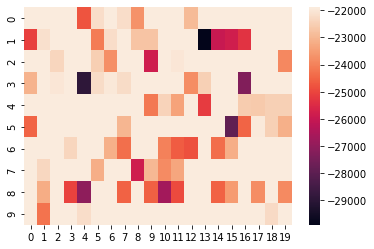

In [10]:
X=20
Y=10
pop_knap=create_knap_pop(dic,Y,X)
pop_tsp=create_tsp_pop(dic,Y,X)
fitness=fit_loop(dic,pop_tsp,pop_knap)
#iterations=1000
mr=.1
l=0
z=True
count=0
lastfit=np.amax(fitness)
while z:
    fitness=fit_loop(dic,pop_tsp,pop_knap)
    pop_knap,pop_tsp=cga.crossover(fitness,pop_knap,pop_tsp,Y,X,mr) 
    print("generation: ",l, " maximo: ", np.amax(fitness))
    l=l+1
    fitness=fit_loop(dic,pop_tsp,pop_knap)
    if lastfit>=np.amax(fitness):
        count=count+1
    else:
        count=0
    lastfit=np.amax(fitness)
    if count==100 :
        z=False

#print(maximos)

p1 = sns.heatmap(fitness)    
